# Example of Graph Neural Network

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# import seaborn as sns
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import wandb

import warnings

warnings.filterwarnings("ignore")
sys.path.append("../../..")
device = "cuda" if torch.cuda.is_available() else "cpu"

## Setup

In [2]:
from LightningModules.GNN.Models.interaction_gnn import InteractionGNN
from LightningModules.GNN.Models.checkpoint_pyramid import CheckpointedPyramid

In [12]:
with open("example_gnn.yaml") as f:
    hparams = yaml.load(f, Loader=yaml.FullLoader)

In [13]:
model = InteractionGNN(hparams)

## Weight Initialisation

In [30]:
from torch.nn import Linear
import seaborn as sns

In [52]:
for layer in model.modules():
    if type(layer) is Linear:
        torch.nn.init.sparse_(layer.weight, 0.1)
        layer.bias.data.fill_(0)
        print("Linear!")
        # print(layer.weight)
        # print(layer.bias)
    else:
        print("Not linear!")

Not linear!
Not linear!
Linear!
Not linear!
Not linear!
Linear!
Not linear!
Not linear!
Linear!
Not linear!
Linear!
Not linear!
Not linear!
Linear!
Not linear!
Not linear!
Linear!
Not linear!
Not linear!
Linear!
Not linear!
Linear!
Not linear!
Not linear!
Linear!
Not linear!
Not linear!
Linear!


In [27]:
layer.weight.flatten()

tensor([ 0.0023, -0.0288,  0.0074,  ..., -0.0551, -0.0289,  0.0239],
       grad_fn=<ViewBackward>)

Default

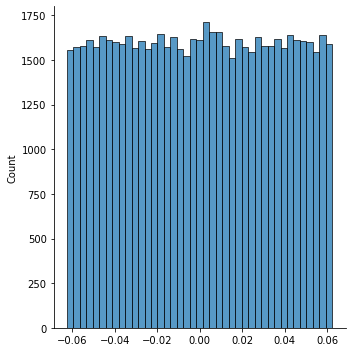

In [32]:
sns.displot(layer.weight.flatten().detach().numpy())

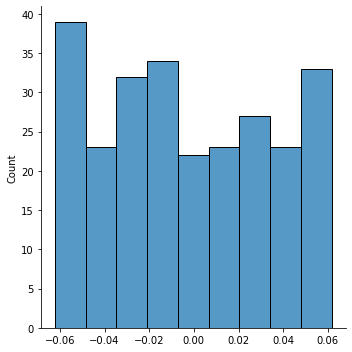

In [33]:
sns.displot(layer.bias.detach().numpy())

PyG recommendation (Xavier uniform with 0 bias)

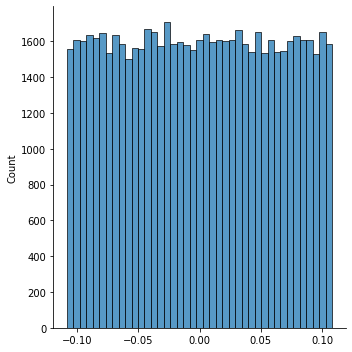

In [37]:
sns.displot(layer.weight.flatten().detach().numpy())

Xavier normal

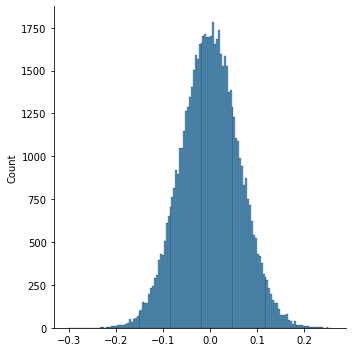

In [40]:
sns.displot(layer.weight.flatten().detach().numpy())

Kaiming uniform

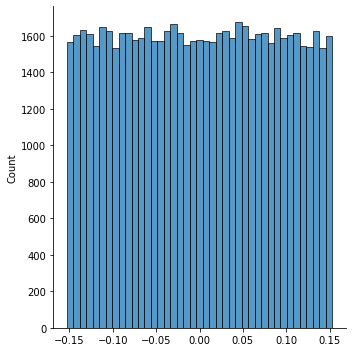

In [43]:
sns.displot(layer.weight.flatten().detach().numpy())

Kaiming normal

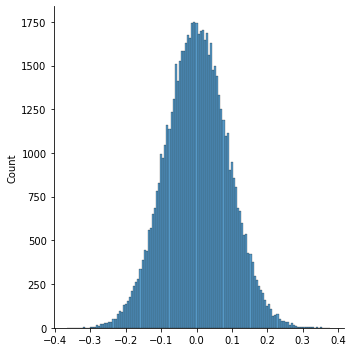

In [45]:
sns.displot(layer.weight.flatten().detach().numpy())

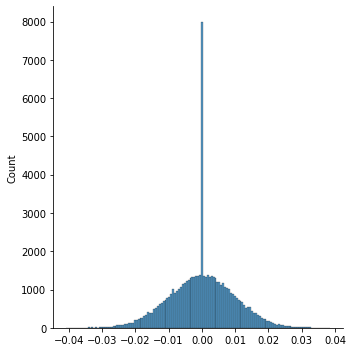

In [53]:
sns.displot(layer.weight.flatten().detach().numpy())

### Dataset

In [6]:
%%time
model.setup(stage="fit")

CPU times: user 4.15 s, sys: 834 ms, total: 4.98 s
Wall time: 1.66 s


In [7]:
sample = model.trainset[0]

In [8]:
sample

Data(cell_data=[52573, 11], edge_index=[2, 40419], event_file="/project/projectdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001", hid=[52573], modulewise_true_edges=[2, 46739], nhits=[52573], pid=[52573], primary=[52573], pt=[52573], signal_true_edges=[2, 13312], x=[52573, 3], y=[40419], y_pid=[287180])

In [9]:
sample.y.sum() / sample.signal_true_edges.shape[1]

tensor(0.9715)

In [11]:
sample.y.sum() / sample.edge_index.shape[1]

tensor(0.3199)

In [13]:
edges = sample.edge_index

In [13]:
pid = sample.pid

In [14]:
edges.shape

torch.Size([2, 287180])

In [14]:
(sample.pid[edges[0]] == sample.pid[edges[1]]).sum() / sample.edge_index.shape[1]

tensor(0.5314)

## Memory Test

In [5]:
%%time
model.setup(stage="fit")

Setting up dataset
Loading events
Events loaded!
Events processed!
Loading events
Events loaded!
Events processed!
Loading events
Events loaded!
Events processed!
CPU times: user 119 ms, sys: 354 ms, total: 472 ms
Wall time: 897 ms


In [6]:
sample = model.trainset[0].to(device)

In [7]:
sample

Data(cell_data=[96465, 11], edge_index=[2, 261315], event_file="/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001", hid=[96465], modulewise_true_edges=[2, 37882], nhits=[96465], pid=[96465], primary=[96465], pt=[96465], signal_true_edges=[2, 5305], x=[96465, 3], y=[261315], y_pid=[261315])

In [8]:
model = model.to(device)

In [14]:
torch.cuda.reset_peak_memory_stats()
output = model(
    torch.cat([sample.x.to(device), sample.cell_data.to(device)], dim=-1),
    sample.edge_index.to(device),
)

RuntimeError: you can only change requires_grad flags of leaf variables.

In [ ]:
print(torch.cuda.max_memory_allocated() / 1024**3, "Gb")

In [8]:
num_spacepoints = 10000
included_spacepoints = torch.randperm(len(sample.x))[:num_spacepoints]

In [26]:
%%time
included_edges = sample.edge_index[:, ..., None].cpu() == included_spacepoints

CPU times: user 5.23 s, sys: 8.45 s, total: 13.7 s
Wall time: 10.3 s


In [ ]:
%%time
included_edges = included_edges.any(-1)

In [14]:
included_edges = np.isin(sample.edge_index.cpu(), included_spacepoints).any(0)

In [15]:
included_edges

array([ True,  True,  True, ...,  True,  True,  True])

In [10]:
memory = []

for i in np.arange(1000, 21000, 1000):

    model.zero_grad()

    included_spacepoints = torch.randperm(len(sample.x))[:i]
    included_edges = np.isin(sample.edge_index.cpu(), included_spacepoints).any(0)

    torch.cuda.reset_peak_memory_stats()
    output = model(sample.x, sample.edge_index[:, included_edges])

    memory.append(torch.cuda.max_memory_allocated() / 1024**3)
    print(torch.cuda.max_memory_allocated() / 1024**3)

0.5790920257568359
1.3435134887695312
1.9847655296325684
2.6116480827331543
3.185835838317871
3.735934257507324
4.259364604949951
4.746316909790039
5.193796634674072
5.612252235412598
5.989464282989502
6.338123321533203
6.654370307922363
6.938986778259277
7.183849811553955
7.39341402053833
7.569871425628662
7.715198993682861
7.831214427947998
7.911214828491211


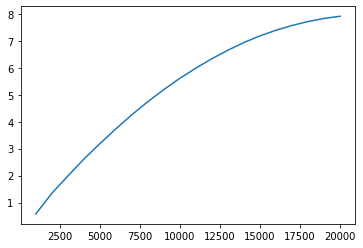

In [11]:
plt.plot(np.arange(1000, 21000, 1000), memory)

In [ ]:
included_spacepoints

In [10]:
import ninja

In [8]:
from pytorch_lightning.plugins import DeepSpeedPlugin

In [11]:
logger = WandbLogger(project="ITk_0.5GeV_GNN", group="InitialTest")
trainer = Trainer(
    gpus=1,
    max_epochs=1,
    logger=logger,
    plugins=DeepSpeedPlugin(
        stage=3,
        offload_optimizer=True,
        offload_parameters=True,
    ),
    precision=16,
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
initializing deepspeed distributed: GLOBAL_RANK: 0, MEMBER: 1/1
Enabling DeepSpeed FP16.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[2021-10-01 17:58:50,044] [WARNING] [partition_parameters.py:456:__init__] zero.Init: the `config` argument is deprecated. Please use `config_dict_or_path` instead.


You have not specified an optimizer or scheduler within the DeepSpeed config.Using `configure_optimizers` to define optimizer and scheduler.


Initializing ZeRO Stage 3
Using /global/u2/d/danieltm/.cache/torch_extensions as PyTorch extensions root...
No modifications detected for re-loaded extension module utils, skipping build step...
Loading extension module utils...


ImportError: /global/u2/d/danieltm/.cache/torch_extensions/utils/utils.so: cannot open shared object file: No such file or directory

## Dataset Validation

In [14]:
%%time
model.setup(stage="fit")

CPU times: user 13.3 ms, sys: 179 µs, total: 13.5 ms
Wall time: 34.8 ms


In [15]:
positive, true, true_positive = [], [], []

for event in tqdm(model.trainset):
    positive.append(event.edge_index.shape[1])
    true.append(event.signal_true_edges.shape[1])
    true_positive.append(event.y.sum())
    
positive, true, true_positive = np.array(positive), np.array(true), np.array(true_positive)

100%|██████████| 200/200 [01:16<00:00,  2.62it/s]


In [16]:
np.mean(true_positive) / np.mean(true), np.mean(true_positive) / np.mean(positive)

(0.9687628522464191, 0.02206025306278469)

In [17]:
np.mean(true_positive), np.mean(true), np.mean(positive)

(13402.96, 13835.13, 607561.48)

In [18]:
np.std(true_positive), np.std(true), np.std(positive)

(1720.109455354513, 1763.7368605038564, 117155.54362278209)

In [7]:
sample = model.trainset[0]

In [8]:
sample

Data(x=[96465, 3], cell_data=[96465, 11], pid=[96465], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001', hid=[96465], pt=[96465], primary=[96465], nhits=[96465], modulewise_true_edges=[2, 37882], signal_true_edges=[2, 5305], edge_index=[2, 402112], y=[402112], pedigree=[1], y_pid=[402112])

In [6]:
tg, pid, tg_pid, pid_tg, both = [], [], [], [], []

for event in model.trainset:
    y, y_pid = event.y.bool(), event.y_pid.bool()
    tg.append(y.sum())
    pid.append(y_pid.sum())
    tg_pid.append((y & ~y_pid).sum())
    pid_tg.append((y_pid & ~y).sum())
    both.append((y & y_pid).sum())
    
tg, pid, tg_pid, pid_tg, both = np.array(tg), np.array(pid), np.array(tg_pid), np.array(pid_tg), np.array(both)

In [7]:
np.mean(tg), np.mean(pid), np.mean(tg_pid), np.mean(pid_tg), np.mean(both)

(5470.12, 18233.75, 0.0, 12763.63, 5470.12)

In [8]:
np.std(tg), np.std(pid), np.std(tg_pid), np.std(pid_tg), np.std(both)

(684.6093379439109,
 2001.6332899659717,
 0.0,
 1352.5695816112382,
 684.6093379439109)

In [54]:
sample

Data(x=[96465, 3], cell_data=[96465, 11], pid=[96465], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001', hid=[96465], pt=[96465], primary=[96465], nhits=[96465], modulewise_true_edges=[2, 37882], signal_true_edges=[2, 5305], edge_index=[2, 402112], y=[402112], pedigree=[1], y_pid=[402112])

In [8]:
x, y, y_pid, pid, pid_signal, e, e_true, pt, primary, nhits = sample.x, sample.y.bool(), sample.y_pid.bool(), sample.pid, sample.pid_signal, sample.edge_index, sample.signal_true_edges, sample.pt, sample.primary, sample.nhits

In [9]:
(y & ~y_pid).sum()

tensor(0)

In [10]:
(~y & y_pid).sum()

tensor(13503)

In [11]:
(y & y_pid).sum()

tensor(5239)

In [12]:
y.sum()

tensor(5239)

In [13]:
y_pid.sum()

tensor(18742)

In [14]:
pid_tg = y_pid & ~y
tg_pid = y & ~y_pid
both = y & y_pid

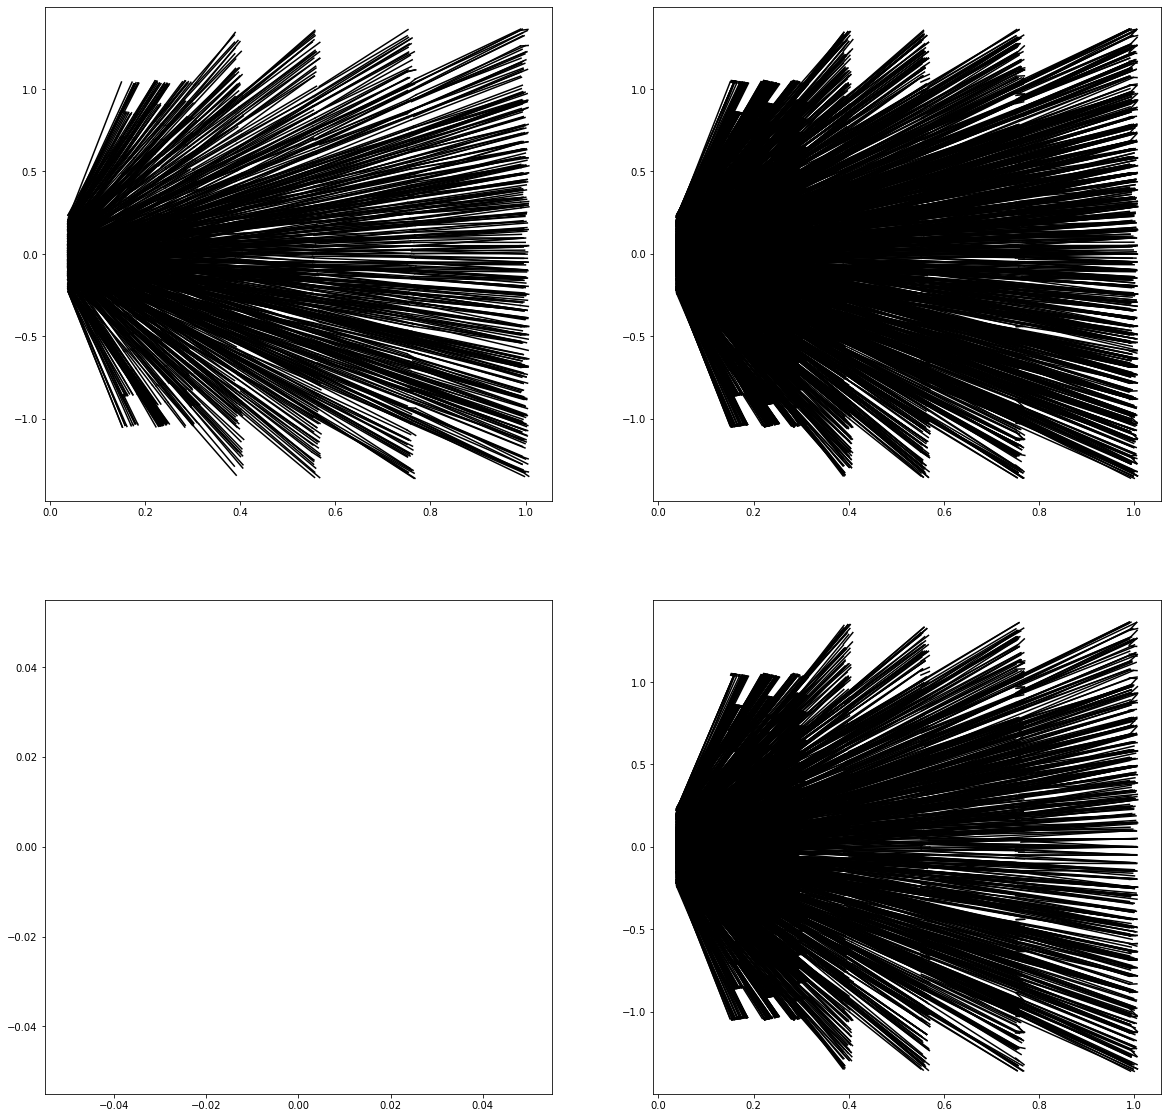

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(20,20));
axs[0, 0].plot(x[e[:, y], 0], x[e[:, y], 2], c="k");
axs[0, 1].plot(x[e[:, y_pid], 0], x[e[:, y_pid], 2], c="k");
axs[1, 0].plot(x[e[:, y & ~y_pid], 0], x[e[:, y & ~y_pid], 2], c="k");
axs[1, 1].plot(x[e[:, ~y & y_pid], 0], x[e[:, ~y & y_pid], 2], c="k");

### First, Understand PID-TG

In [15]:
pid_tg_e = e[:, pid_tg]
tg_pid_e = e[:, tg_pid]
tg_e = e[:, y]
pid_e = e[:, y_pid]
both_e = e[:, both]

In [53]:
pid[pid_tg_e]

tensor([[16340000575, 15690000105, 15900000329,  ...,        2159,
         16300200825, 14570001069],
        [16340000575, 15690000105, 15900000329,  ...,        2159,
         16300200825, 14570001069]])

<AxesSubplot:ylabel='Count'>

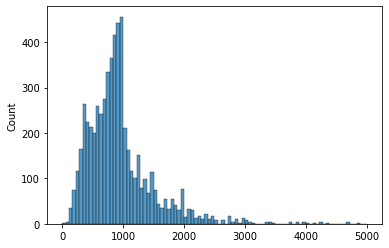

In [71]:
sns.histplot(pt[pid_tg_e][0], binrange=(0, 5000))

In [78]:
pid[pid_tg_e[:, pt[pid_tg_e][0] > 1000]]

tensor([[15350000113, 15320000701,        1309,  ..., 15420000471,
         15850200291,      200015],
        [15350000113, 15320000701,        1309,  ..., 15420000471,
         15850200291,      200015]])

In [79]:
nhits[pid_tg_e[:, pt[pid_tg_e][0] > 1000]]

tensor([[ 9, 11,  2,  ..., 11, 10,  7],
        [ 9, 11,  2,  ..., 11, 10,  7]])

In [80]:
primary[pid_tg_e[:, pt[pid_tg_e][0] > 1000]]

tensor([[1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 0., 0.]], dtype=torch.float64)

In [89]:
(pid[pid_tg_e][0] == 15350000113).sum(), (pid[tg_pid_e][0] == 15350000113).sum(), (pid[tg_e][0] == 15350000113).sum(), (pid[pid_e][0] == 15350000113).sum()

(tensor(3), tensor(0), tensor(8), tensor(11))

In [92]:
e_true[:, (pid[e_true] == 15350000113).any(0)]

tensor([[  144,  9393, 16252, 32429, 47186, 60093, 72699, 91172],
        [ 9393, 16252, 32429, 47186, 60093, 72699, 91172, 96404]])

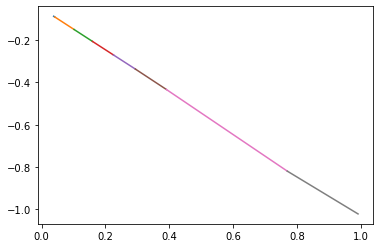

In [96]:
plt.plot(x[e_true[:, (pid[e_true] == 15350000113).any(0)], 0], x[e_true[:, (pid[e_true] == 15350000113).any(0)], 2])

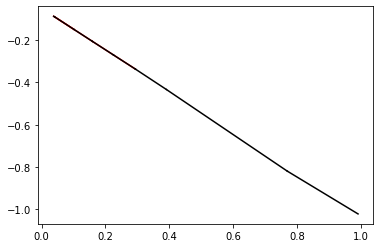

In [99]:
plt.plot(x[pid_tg_e[:, pid[pid_tg_e][0] == 15350000113], 0], x[pid_tg_e[:, pid[pid_tg_e][0] == 15350000113], 2], c="r")
plt.plot(x[tg_e[:, pid[tg_e][0] == 15350000113], 0], x[tg_e[:, pid[tg_e][0] == 15350000113], 2], c="k")


In [94]:
tg_e[:, pid[tg_e][0] == 15350000113]

tensor([[ 9393, 16252, 32429, 47186, 47186, 60093, 72699, 91172],
        [  144,  9393, 16252, 32429, 60093, 72699, 91172, 96404]])

In [95]:
pid_tg_e[:, pid[pid_tg_e][0] == 15350000113]

tensor([[  144, 32429, 32429],
        [16252,  9393, 60093]])

Okay... I think I understand this

In [107]:
pt[pid_tg_e][0] > 1000

tensor([False, False, False,  ..., False, False, False])

In [110]:
nhits[pid_tg_e][0] >= 3

tensor([True, True, True,  ..., True, True, True])

In [105]:
primary[pid_tg_e][0]

tensor([1., 1., 1.,  ..., 1., nan, 1.], dtype=torch.float64)

In [113]:
print(f"Total PID: {y_pid.sum()}, PID - TG: {pid_tg.sum()}, >1GeV: {(pt[pid_tg_e][0] > 1000).sum()}, and >=3 hits & primary: {((pt[pid_tg_e][0] > 1000) & (nhits[pid_tg_e][0] >= 3) & (primary[pid_tg_e][0].bool())).sum()}")

Total PID: 8497, PID - TG: 6015, >1GeV: 1846, and >=3 hits & primary: 1546


### Second, Understand TG-PID

In [120]:
torch.where(y), torch.where(y_pid), torch.where(tg_pid)

((tensor([279075, 279091, 279105,  ..., 402083, 402088, 402108]),),
 (tensor([278972, 278983, 279056,  ..., 402104, 402107, 402109]),),
 (tensor([279075, 279113, 279118,  ..., 402077, 402083, 402108]),))

In [131]:
print(torch.where(y_pid)[0][:10])

tensor([278972, 278983, 279056, 279057, 279059, 279060, 279086, 279091, 279092,
        279093])


In [145]:
e[:, 279075]

tensor([9363,  124])

In [155]:
(pid[e[:, 279075]][0] == pid[e[:, 279075]][1]) & pid[e[:, 279075]][0].bool()

tensor(True)

In [154]:
pid[e[:, 279075]][0].bool()

tensor(True)

In [149]:
y_pid[279075]

tensor(False)

In [148]:
y_pid

tensor([False, False, False,  ...,  True, False, False])

In [136]:
tg_pid

tensor(2658)

In [115]:
pid[tg_pid_e]

tensor([[15350000114, 16300000922, 14860000162,  ..., 14640000414,
         15050000214, 14520000552],
        [15350000114, 16300000922, 14860000162,  ..., 14640000414,
         15050000214, 14520000552]])

In [134]:
(pid[tg_pid_e][0] == pid[tg_pid_e][1]).sum()

tensor(2658)

In [135]:
tg_pid.sum()

tensor(2658)

In [117]:
pid[pid_e]

tensor([[16340000575, 15690000105, 15900000329,  ...,        2159,
         16300200825, 14570001069],
        [16340000575, 15690000105, 15900000329,  ...,        2159,
         16300200825, 14570001069]])

In [144]:
sample.y_pid.sum()

tensor(8497)

In [ ]:
sample.pid

In [142]:
(both & tg_pid).sum()

tensor(0)

### Input Graphs

In [19]:
graph_sizes = []

for graph in tqdm(model.trainset):
    graph_sizes.append(graph.edge_index.shape[1])

100%|██████████| 200/200 [00:30<00:00,  6.59it/s]


<AxesSubplot:ylabel='Count'>

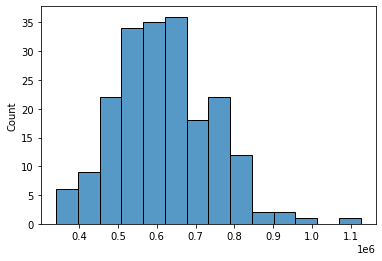

In [20]:
sns.histplot(graph_sizes)

In [6]:
sample = model.trainset[0]

In [7]:
sample

Data(x=[105644, 3], cell_data=[105644, 11], pid=[105644], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000017162', hid=[105644], pt=[105644], primary=[105644], nhits=[105644], modulewise_true_edges=[2, 40528], signal_true_edges=[2, 5754], edge_index=[2, 480999], y=[480999], pedigree=[1], y_pid=[480999])

In [18]:
sample.y_pid

tensor([False, False, False,  ..., False, False,  True])

In [18]:
sample.y_pid.sum()

tensor(18742)

In [17]:
sample.y.sum()

tensor(5239.)

In [25]:
torch.isin(sample.edge_index, sample.signal_true_edges).any(0) & sample.y_pid

tensor([False, False, False,  ..., False, False, False])

In [27]:
sample.

tensor(5239)

In [13]:
pid_e.shape

torch.Size([2, 18238])

In [ ]:
sample.pid

## Train GNN

In [5]:
logger = WandbLogger(
    project=hparams["project"], group="InitialTest", save_dir=hparams["artifacts"]
)
trainer = Trainer(
    gpus=1, max_epochs=hparams["max_epochs"], logger=logger
)  # , precision=16)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Setting up dataset
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/filter_processed/0GeV_barrel_v3/train


100%|██████████| 40/40 [00:02<00:00, 13.67it/s]


Events loaded!


40it [00:01, 20.37it/s]


Events processed!
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/filter_processed/0GeV_barrel_v3/val


100%|██████████| 20/20 [00:01<00:00, 16.30it/s]


Events loaded!


20it [00:00, 20.25it/s]


Events processed!
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/filter_processed/0GeV_barrel_v3/test


100%|██████████| 10/10 [00:00<00:00, 13.57it/s]


Events loaded!


10it [00:00, 20.23it/s]
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Events processed!


wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 34.6 K
1 | edge_encoder           | Sequential | 66.9 K
2 | edge_network           | Sequential | 83.3 K
3 | node_network           | Sequential | 83.3 K
4 | output_edge_classifier | Sequential | 84.0 K
------------------------------------------------------
352 K     Trainable params
0         Non-trainable params
352 K     Total params
1.409     Total estimated model params size (MB)


Epoch 0:  67%|██████▋   | 40/60 [01:10<00:35,  1.77s/it, loss=0.478, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 1:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.329, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 2:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.299, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 3:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.276, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 4:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.264, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 5:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.254, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 6:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.247, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 7:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.241, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 8:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.238, v_num=4hnm]
Validating: 0it [00:00,

## Build Classified Files

In [5]:
from notebooks.ITk.utils import GNNInferenceCallback

In [6]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_GNN/1j1uwy9r/checkpoints/epoch=76-step=38499.ckpt"
checkpoint = torch.load(checkpoint_path)
model = InteractionGNN.load_from_checkpoint(checkpoint_path).to(device)
model.eval();

In [14]:
model.hparams["datatype_split"] = [4000, 100, 50]
model.setup(stage="fit")

In [15]:
model = model.to(device)

In [18]:
builder = GNNInferenceCallback(model, overwrite=False)

In [19]:
builder.infer()

Training finished, running inference to filter graphs...
Building train


 93%|█████████▎| 3738/4000 [1:43:57<08:24,  1.93s/it]  

In [74]:
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for batch in model.train_dataloader():

        print(batch)

        output = model.shared_evaluation(batch.to(device), 0, log=False)

        print(output)
        print(os.path.split(batch.event_file[0])[-1])

        gnn_results = np.vstack(
            [
                batch.edge_index.cpu().numpy(),
                output["score"][: int(len(output["score"]) / 2)].cpu().numpy(),
                output["truth"].cpu().numpy(),
            ]
        )

        gnn_recarray = np.rec.fromarrays(
            gnn_results, names=["senders", "receivers", "score", "truth"]
        )

        with open(
            os.path.join(
                output_dir, os.path.split(batch.event_file[0])[-1][-4:] + ".npz"
            ),
            "wb",
        ) as f:
            np.save(f, gnn_recarray)

Batch(batch=[21428], cell_data=[21428, 11], edge_index=[2, 182327], event_file=[1], hid=[21428], modulewise_true_edges=[2, 17889], nhits=[21428], pid=[21428], primary=[21428], pt=[21428], ptr=[2], signal_true_edges=[2, 14822], x=[21428, 3], y=[182327], y_pid=[182327])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0277, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.8932e-02, 1.9480e-04, 2.3910e-04,  ..., 1.0017e-04, 2.6190e-05,
        4.1214e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010001
Batch(batch=[20316], cell_data=[20316, 11], edge_index=[2, 160427], event_file=[1], hid=[20316], modulewise_true_edges=[2, 16859], nhits=[20316], pid=[20316], primary=[20316], pt=[20316], ptr=[2], signal_true_edges=[2, 13654], x=[20316, 3], y=[160427], y_pid=[160427])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0301, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.6138e-03, 4.3948e-05, 1.0922e-04,  ..., 2.7575e-04, 2.6210e-04,
        2.8092e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010002
Batch(batch=[26360], cell_data=[26360, 11], edge_index=[2, 263389], event_file=[1], hid=[26360], modulewise_true_edges=[2, 21995], nhits=[26360], pid=[26360], primary=[26360], pt=[26360], ptr=[2], signal_true_edges=[2, 18093], x=[26360, 3], y=[263389], y_pid=[263389])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0263, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.8291e-03, 3.0076e-03, 3.2153e-04,  ..., 1.0838e-04, 3.1777e-05,
        4.8927e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010003
Batch(batch=[18174], cell_data=[18174, 11], edge_index=[2, 129874], event_file=[1], hid=[18174], modulewise_true_edges=[2, 15083], nhits=[18174], pid=[18174], primary=[18174], pt=[18174], ptr=[2], signal_true_edges=[2, 12223], x=[18174, 3], y=[129874], y_pid=[129874])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0307, device='cuda:0'), 'preds': tensor([False,  True, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([5.5092e-06, 8.9512e-01, 1.9343e-01,  ..., 6.6806e-01, 5.4391e-04,
        1.5399e-03], device='cuda:0'), 'truth': tensor([False,  True, False,  ..., False, False, False], device='cuda:0')}
event000010004
Batch(batch=[24514], cell_data=[24514, 11], edge_index=[2, 229935], event_file=[1], hid=[24514], modulewise_true_edges=[2, 20441], nhits=[24514], pid=[24514], primary=[24514], pt=[24514], ptr=[2], signal_true_edges=[2, 16733], x=[24514, 3], y=[229935], y_pid=[229935])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0265, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.7308e-05, 2.0252e-03, 1.1878e-05,  ..., 2.1065e-05, 3.6906e-05,
        1.4867e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010005
Batch(batch=[23987], cell_data=[23987, 11], edge_index=[2, 219135], event_file=[1], hid=[23987], modulewise_true_edges=[2, 19975], nhits=[23987], pid=[23987], primary=[23987], pt=[23987], ptr=[2], signal_true_edges=[2, 16222], x=[23987, 3], y=[219135], y_pid=[219135])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0284, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.8506e-04, 8.0432e-05, 6.9039e-02,  ..., 4.1239e-04, 3.3575e-05,
        1.8252e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010006
Batch(batch=[26395], cell_data=[26395, 11], edge_index=[2, 265622], event_file=[1], hid=[26395], modulewise_true_edges=[2, 21990], nhits=[26395], pid=[26395], primary=[26395], pt=[26395], ptr=[2], signal_true_edges=[2, 18135], x=[26395, 3], y=[265622], y_pid=[265622])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0268, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.9568e-03, 2.2322e-03, 1.2444e-04,  ..., 3.8781e-05, 5.6611e-05,
        2.4844e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010007
Batch(batch=[23642], cell_data=[23642, 11], edge_index=[2, 210727], event_file=[1], hid=[23642], modulewise_true_edges=[2, 19656], nhits=[23642], pid=[23642], primary=[23642], pt=[23642], ptr=[2], signal_true_edges=[2, 15961], x=[23642, 3], y=[210727], y_pid=[210727])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0271, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([1.1837e-03, 4.6246e-02, 1.4159e-04,  ..., 9.8720e-01, 4.9774e-05,
        5.9327e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010008
Batch(batch=[21644], cell_data=[21644, 11], edge_index=[2, 179556], event_file=[1], hid=[21644], modulewise_true_edges=[2, 18054], nhits=[21644], pid=[21644], primary=[21644], pt=[21644], ptr=[2], signal_true_edges=[2, 14731], x=[21644, 3], y=[179556], y_pid=[179556])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0282, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.8943e-05, 9.3955e-05, 2.6439e-05,  ..., 9.2367e-05, 5.7389e-03,
        1.1963e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010009
Batch(batch=[18579], cell_data=[18579, 11], edge_index=[2, 139011], event_file=[1], hid=[18579], modulewise_true_edges=[2, 15524], nhits=[18579], pid=[18579], primary=[18579], pt=[18579], ptr=[2], signal_true_edges=[2, 12736], x=[18579, 3], y=[139011], y_pid=[139011])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0293, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.1584e-05, 1.9329e-03, 7.6443e-04,  ..., 3.9833e-05, 6.0347e-03,
        1.9427e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000010
Batch(batch=[23755], cell_data=[23755, 11], edge_index=[2, 215329], event_file=[1], hid=[23755], modulewise_true_edges=[2, 19805], nhits=[23755], pid=[23755], primary=[23755], pt=[23755], ptr=[2], signal_true_edges=[2, 16093], x=[23755, 3], y=[215329], y_pid=[215329])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([7.2475e-05, 2.1563e-04, 6.6669e-03,  ..., 6.9244e-05, 2.1823e-05,
        4.2965e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010011
Batch(batch=[24486], cell_data=[24486, 11], edge_index=[2, 230724], event_file=[1], hid=[24486], modulewise_true_edges=[2, 20471], nhits=[24486], pid=[24486], primary=[24486], pt=[24486], ptr=[2], signal_true_edges=[2, 16737], x=[24486, 3], y=[230724], y_pid=[230724])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0274, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.8733e-05, 5.9391e-05, 1.1947e-03,  ..., 2.1761e-05, 8.3078e-05,
        1.0664e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010012
Batch(batch=[27800], cell_data=[27800, 11], edge_index=[2, 290018], event_file=[1], hid=[27800], modulewise_true_edges=[2, 23195], nhits=[27800], pid=[27800], primary=[27800], pt=[27800], ptr=[2], signal_true_edges=[2, 19120], x=[27800, 3], y=[290018], y_pid=[290018])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0257, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.2905e-05, 2.1112e-05, 3.5255e-05,  ..., 3.2448e-05, 3.7968e-05,
        2.2730e-02], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000013
Batch(batch=[22254], cell_data=[22254, 11], edge_index=[2, 188603], event_file=[1], hid=[22254], modulewise_true_edges=[2, 18592], nhits=[22254], pid=[22254], primary=[22254], pt=[22254], ptr=[2], signal_true_edges=[2, 14831], x=[22254, 3], y=[188603], y_pid=[188603])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0312, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.1150e-01, 3.1438e-03, 4.6768e-02,  ..., 2.1072e-04, 8.9660e-05,
        1.5756e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000014
Batch(batch=[26079], cell_data=[26079, 11], edge_index=[2, 255023], event_file=[1], hid=[26079], modulewise_true_edges=[2, 21710], nhits=[26079], pid=[26079], primary=[26079], pt=[26079], ptr=[2], signal_true_edges=[2, 17521], x=[26079, 3], y=[255023], y_pid=[255023])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0260, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.0003e-05, 3.0932e-05, 5.0317e-04,  ..., 3.3822e-05, 4.3899e-04,
        1.6267e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010015
Batch(batch=[28271], cell_data=[28271, 11], edge_index=[2, 294995], event_file=[1], hid=[28271], modulewise_true_edges=[2, 23563], nhits=[28271], pid=[28271], primary=[28271], pt=[28271], ptr=[2], signal_true_edges=[2, 19285], x=[28271, 3], y=[294995], y_pid=[294995])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0253, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.1327e-04, 9.9773e-05, 1.1746e-02,  ..., 1.0135e-04, 1.3799e-03,
        1.7338e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000016
Batch(batch=[20984], cell_data=[20984, 11], edge_index=[2, 178083], event_file=[1], hid=[20984], modulewise_true_edges=[2, 17572], nhits=[20984], pid=[20984], primary=[20984], pt=[20984], ptr=[2], signal_true_edges=[2, 14676], x=[20984, 3], y=[178083], y_pid=[178083])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0283, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.9859e-05, 8.7187e-04, 3.1649e-04,  ..., 3.1234e-05, 2.5594e-05,
        4.3685e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010017
Batch(batch=[21778], cell_data=[21778, 11], edge_index=[2, 183149], event_file=[1], hid=[21778], modulewise_true_edges=[2, 18105], nhits=[21778], pid=[21778], primary=[21778], pt=[21778], ptr=[2], signal_true_edges=[2, 14739], x=[21778, 3], y=[183149], y_pid=[183149])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0275, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([3.9194e-05, 1.8531e-05, 3.3895e-04,  ..., 8.6424e-02, 9.2667e-01,
        7.2236e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000010018
Batch(batch=[22293], cell_data=[22293, 11], edge_index=[2, 192130], event_file=[1], hid=[22293], modulewise_true_edges=[2, 18618], nhits=[22293], pid=[22293], primary=[22293], pt=[22293], ptr=[2], signal_true_edges=[2, 15249], x=[22293, 3], y=[192130], y_pid=[192130])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0286, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.9632e-03, 6.7009e-04, 3.3854e-04,  ..., 3.8907e-05, 3.1622e-05,
        4.6801e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010019
Batch(batch=[20172], cell_data=[20172, 11], edge_index=[2, 160441], event_file=[1], hid=[20172], modulewise_true_edges=[2, 16722], nhits=[20172], pid=[20172], primary=[20172], pt=[20172], ptr=[2], signal_true_edges=[2, 13308], x=[20172, 3], y=[160441], y_pid=[160441])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0298, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True,  True, False], device='cuda:0'), 'score': tensor([4.2272e-05, 4.3531e-04, 4.1149e-05,  ..., 9.5398e-01, 9.6773e-01,
        4.3507e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True,  True, False], device='cuda:0')}
event000010020
Batch(batch=[24021], cell_data=[24021, 11], edge_index=[2, 219822], event_file=[1], hid=[24021], modulewise_true_edges=[2, 20020], nhits=[24021], pid=[24021], primary=[24021], pt=[24021], ptr=[2], signal_true_edges=[2, 16230], x=[24021, 3], y=[219822], y_pid=[219822])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0274, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.7873e-04, 4.3362e-04, 3.8116e-02,  ..., 3.4574e-05, 5.2713e-05,
        3.6613e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010021
Batch(batch=[23001], cell_data=[23001, 11], edge_index=[2, 207274], event_file=[1], hid=[23001], modulewise_true_edges=[2, 19226], nhits=[23001], pid=[23001], primary=[23001], pt=[23001], ptr=[2], signal_true_edges=[2, 15492], x=[23001, 3], y=[207274], y_pid=[207274])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0281, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.9382e-04, 2.1594e-05, 2.9297e-03,  ..., 6.4310e-05, 2.7842e-05,
        2.2965e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010022
Batch(batch=[25299], cell_data=[25299, 11], edge_index=[2, 241603], event_file=[1], hid=[25299], modulewise_true_edges=[2, 21043], nhits=[25299], pid=[25299], primary=[25299], pt=[25299], ptr=[2], signal_true_edges=[2, 16918], x=[25299, 3], y=[241603], y_pid=[241603])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0268, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.9455e-05, 4.9416e-05, 7.0470e-04,  ..., 5.7158e-05, 1.8878e-03,
        1.0594e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010023
Batch(batch=[20795], cell_data=[20795, 11], edge_index=[2, 169503], event_file=[1], hid=[20795], modulewise_true_edges=[2, 17321], nhits=[20795], pid=[20795], primary=[20795], pt=[20795], ptr=[2], signal_true_edges=[2, 13960], x=[20795, 3], y=[169503], y_pid=[169503])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0283, device='cuda:0'), 'preds': tensor([ True, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.2110e-01, 2.3546e-05, 2.5641e-05,  ..., 2.1161e-05, 5.0279e-05,
        4.2146e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010024
Batch(batch=[24192], cell_data=[24192, 11], edge_index=[2, 224066], event_file=[1], hid=[24192], modulewise_true_edges=[2, 20247], nhits=[24192], pid=[24192], primary=[24192], pt=[24192], ptr=[2], signal_true_edges=[2, 16865], x=[24192, 3], y=[224066], y_pid=[224066])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0249, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.6826e-03, 4.4730e-02, 4.5096e-02,  ..., 2.3395e-04, 2.1430e-05,
        1.9421e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010025
Batch(batch=[21489], cell_data=[21489, 11], edge_index=[2, 178211], event_file=[1], hid=[21489], modulewise_true_edges=[2, 17876], nhits=[21489], pid=[21489], primary=[21489], pt=[21489], ptr=[2], signal_true_edges=[2, 14460], x=[21489, 3], y=[178211], y_pid=[178211])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0274, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.4567e-04, 3.5458e-03, 1.7688e-02,  ..., 1.2180e-04, 1.3061e-02,
        4.0153e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010026
Batch(batch=[26647], cell_data=[26647, 11], edge_index=[2, 268852], event_file=[1], hid=[26647], modulewise_true_edges=[2, 22304], nhits=[26647], pid=[26647], primary=[26647], pt=[26647], ptr=[2], signal_true_edges=[2, 18506], x=[26647, 3], y=[268852], y_pid=[268852])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0243, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.1196e-01, 8.7825e-02, 1.2804e-01,  ..., 2.9982e-05, 1.1824e-04,
        1.9726e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010027
Batch(batch=[20685], cell_data=[20685, 11], edge_index=[2, 169376], event_file=[1], hid=[20685], modulewise_true_edges=[2, 17289], nhits=[20685], pid=[20685], primary=[20685], pt=[20685], ptr=[2], signal_true_edges=[2, 14076], x=[20685, 3], y=[169376], y_pid=[169376])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0300, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.3465e-04, 5.4805e-03, 9.9128e-04,  ..., 4.9970e-04, 6.1716e-05,
        6.0986e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010028
Batch(batch=[21497], cell_data=[21497, 11], edge_index=[2, 179285], event_file=[1], hid=[21497], modulewise_true_edges=[2, 17902], nhits=[21497], pid=[21497], primary=[21497], pt=[21497], ptr=[2], signal_true_edges=[2, 14792], x=[21497, 3], y=[179285], y_pid=[179285])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0274, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.0511e-04, 4.2780e-05, 1.6422e-03,  ..., 1.2313e-04, 2.6159e-05,
        3.8844e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010029
Batch(batch=[25457], cell_data=[25457, 11], edge_index=[2, 242508], event_file=[1], hid=[25457], modulewise_true_edges=[2, 21173], nhits=[25457], pid=[25457], primary=[25457], pt=[25457], ptr=[2], signal_true_edges=[2, 17002], x=[25457, 3], y=[242508], y_pid=[242508])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0268, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.5089e-05, 4.5615e-05, 5.3410e-04,  ..., 1.3931e-04, 3.0329e-05,
        8.0128e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010030
Batch(batch=[22202], cell_data=[22202, 11], edge_index=[2, 194020], event_file=[1], hid=[22202], modulewise_true_edges=[2, 18520], nhits=[22202], pid=[22202], primary=[22202], pt=[22202], ptr=[2], signal_true_edges=[2, 15130], x=[22202, 3], y=[194020], y_pid=[194020])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0286, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.9504e-05, 6.4425e-05, 1.2948e-05,  ..., 4.8013e-01, 6.0664e-03,
        6.8516e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010031
Batch(batch=[23902], cell_data=[23902, 11], edge_index=[2, 217622], event_file=[1], hid=[23902], modulewise_true_edges=[2, 19955], nhits=[23902], pid=[23902], primary=[23902], pt=[23902], ptr=[2], signal_true_edges=[2, 16431], x=[23902, 3], y=[217622], y_pid=[217622])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0257, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.9839e-03, 3.9295e-02, 2.5791e-04,  ..., 4.6477e-05, 5.8254e-05,
        2.5316e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010032
Batch(batch=[19957], cell_data=[19957, 11], edge_index=[2, 157040], event_file=[1], hid=[19957], modulewise_true_edges=[2, 16641], nhits=[19957], pid=[19957], primary=[19957], pt=[19957], ptr=[2], signal_true_edges=[2, 13524], x=[19957, 3], y=[157040], y_pid=[157040])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0282, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.9326e-03, 1.2078e-03, 5.1929e-04,  ..., 1.0380e-02, 1.0188e-04,
        4.0395e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010033
Batch(batch=[24890], cell_data=[24890, 11], edge_index=[2, 234865], event_file=[1], hid=[24890], modulewise_true_edges=[2, 20812], nhits=[24890], pid=[24890], primary=[24890], pt=[24890], ptr=[2], signal_true_edges=[2, 16805], x=[24890, 3], y=[234865], y_pid=[234865])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0281, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.1425e-01, 5.4731e-02, 6.2647e-03,  ..., 3.3508e-05, 4.4361e-05,
        3.9584e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010034
Batch(batch=[24625], cell_data=[24625, 11], edge_index=[2, 230806], event_file=[1], hid=[24625], modulewise_true_edges=[2, 20500], nhits=[24625], pid=[24625], primary=[24625], pt=[24625], ptr=[2], signal_true_edges=[2, 16572], x=[24625, 3], y=[230806], y_pid=[230806])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0267, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.6939e-01, 1.0924e-04, 1.2319e-01,  ..., 2.8514e-04, 3.4112e-03,
        1.4595e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010035
Batch(batch=[24600], cell_data=[24600, 11], edge_index=[2, 229699], event_file=[1], hid=[24600], modulewise_true_edges=[2, 20461], nhits=[24600], pid=[24600], primary=[24600], pt=[24600], ptr=[2], signal_true_edges=[2, 16746], x=[24600, 3], y=[229699], y_pid=[229699])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0268, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0932e-05, 2.8524e-05, 3.4837e-02,  ..., 3.4418e-04, 4.4836e-04,
        1.2705e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010036
Batch(batch=[23051], cell_data=[23051, 11], edge_index=[2, 207323], event_file=[1], hid=[23051], modulewise_true_edges=[2, 19185], nhits=[23051], pid=[23051], primary=[23051], pt=[23051], ptr=[2], signal_true_edges=[2, 15557], x=[23051, 3], y=[207323], y_pid=[207323])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0271, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.1492e-02, 4.0461e-05, 1.6262e-02,  ..., 4.1892e-05, 7.4595e-05,
        4.2001e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010037
Batch(batch=[20044], cell_data=[20044, 11], edge_index=[2, 157374], event_file=[1], hid=[20044], modulewise_true_edges=[2, 16641], nhits=[20044], pid=[20044], primary=[20044], pt=[20044], ptr=[2], signal_true_edges=[2, 13317], x=[20044, 3], y=[157374], y_pid=[157374])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.0449e-05, 5.1597e-05, 4.2985e-05,  ..., 1.9912e-04, 4.5393e-05,
        9.1812e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010038
Batch(batch=[16236], cell_data=[16236, 11], edge_index=[2, 108658], event_file=[1], hid=[16236], modulewise_true_edges=[2, 13530], nhits=[16236], pid=[16236], primary=[16236], pt=[16236], ptr=[2], signal_true_edges=[2, 10902], x=[16236, 3], y=[108658], y_pid=[108658])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0303, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([3.4304e-05, 2.6879e-05, 3.0470e-05,  ..., 9.7690e-01, 3.3015e-01,
        2.9856e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True,  True, False], device='cuda:0')}
event000010039
Batch(batch=[23266], cell_data=[23266, 11], edge_index=[2, 211215], event_file=[1], hid=[23266], modulewise_true_edges=[2, 19459], nhits=[23266], pid=[23266], primary=[23266], pt=[23266], ptr=[2], signal_true_edges=[2, 15737], x=[23266, 3], y=[211215], y_pid=[211215])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0284, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.4802e-05, 2.7216e-04, 2.2414e-05,  ..., 4.5717e-05, 4.1340e-05,
        2.8424e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010040
Batch(batch=[23492], cell_data=[23492, 11], edge_index=[2, 210730], event_file=[1], hid=[23492], modulewise_true_edges=[2, 19582], nhits=[23492], pid=[23492], primary=[23492], pt=[23492], ptr=[2], signal_true_edges=[2, 15956], x=[23492, 3], y=[210730], y_pid=[210730])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.9607e-05, 4.8034e-05, 3.5344e-02,  ..., 4.9563e-05, 2.6898e-05,
        7.6867e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010041
Batch(batch=[18930], cell_data=[18930, 11], edge_index=[2, 145588], event_file=[1], hid=[18930], modulewise_true_edges=[2, 15824], nhits=[18930], pid=[18930], primary=[18930], pt=[18930], ptr=[2], signal_true_edges=[2, 12945], x=[18930, 3], y=[145588], y_pid=[145588])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0305, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.6867e-04, 6.0473e-03, 4.3042e-03,  ..., 4.6396e-04, 9.5223e-05,
        6.4586e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010042
Batch(batch=[21069], cell_data=[21069, 11], edge_index=[2, 174786], event_file=[1], hid=[21069], modulewise_true_edges=[2, 17609], nhits=[21069], pid=[21069], primary=[21069], pt=[21069], ptr=[2], signal_true_edges=[2, 14519], x=[21069, 3], y=[174786], y_pid=[174786])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0272, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0597e-05, 1.6860e-04, 2.2042e-04,  ..., 2.7521e-04, 1.2860e-04,
        1.5116e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010043
Batch(batch=[21988], cell_data=[21988, 11], edge_index=[2, 194110], event_file=[1], hid=[21988], modulewise_true_edges=[2, 18436], nhits=[21988], pid=[21988], primary=[21988], pt=[21988], ptr=[2], signal_true_edges=[2, 15034], x=[21988, 3], y=[194110], y_pid=[194110])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0278, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.6646e-05, 3.3266e-05, 2.3045e-04,  ..., 7.7550e-05, 6.9692e-05,
        4.7959e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010044
Batch(batch=[22205], cell_data=[22205, 11], edge_index=[2, 190772], event_file=[1], hid=[22205], modulewise_true_edges=[2, 18585], nhits=[22205], pid=[22205], primary=[22205], pt=[22205], ptr=[2], signal_true_edges=[2, 15176], x=[22205, 3], y=[190772], y_pid=[190772])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0290, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([9.4069e-05, 1.2017e-05, 1.4129e-05,  ..., 7.2563e-05, 7.4854e-05,
        2.3651e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010045
Batch(batch=[23591], cell_data=[23591, 11], edge_index=[2, 213906], event_file=[1], hid=[23591], modulewise_true_edges=[2, 19684], nhits=[23591], pid=[23591], primary=[23591], pt=[23591], ptr=[2], signal_true_edges=[2, 15987], x=[23591, 3], y=[213906], y_pid=[213906])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0269, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0669e-04, 8.8372e-03, 6.6349e-05,  ..., 1.1393e-04, 3.2810e-05,
        2.4101e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010046
Batch(batch=[23463], cell_data=[23463, 11], edge_index=[2, 210497], event_file=[1], hid=[23463], modulewise_true_edges=[2, 19543], nhits=[23463], pid=[23463], primary=[23463], pt=[23463], ptr=[2], signal_true_edges=[2, 15786], x=[23463, 3], y=[210497], y_pid=[210497])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0266, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.1381e-05, 2.9439e-03, 2.6106e-03,  ..., 5.5127e-05, 2.0711e-05,
        2.9192e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010047
Batch(batch=[22469], cell_data=[22469, 11], edge_index=[2, 194132], event_file=[1], hid=[22469], modulewise_true_edges=[2, 18730], nhits=[22469], pid=[22469], primary=[22469], pt=[22469], ptr=[2], signal_true_edges=[2, 15402], x=[22469, 3], y=[194132], y_pid=[194132])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0266, device='cuda:0'), 'preds': tensor([False,  True, False,  ..., False, False,  True], device='cuda:0'), 'score': tensor([2.0763e-04, 9.8187e-01, 2.8576e-05,  ..., 2.0120e-03, 1.0082e-04,
        9.6499e-01], device='cuda:0'), 'truth': tensor([False,  True, False,  ..., False, False,  True], device='cuda:0')}
event000010048
Batch(batch=[20244], cell_data=[20244, 11], edge_index=[2, 158426], event_file=[1], hid=[20244], modulewise_true_edges=[2, 16864], nhits=[20244], pid=[20244], primary=[20244], pt=[20244], ptr=[2], signal_true_edges=[2, 13791], x=[20244, 3], y=[158426], y_pid=[158426])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0285, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([7.4808e-03, 2.0705e-03, 4.9004e-03,  ..., 2.3101e-05, 7.6211e-05,
        3.8028e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010049
Batch(batch=[25372], cell_data=[25372, 11], edge_index=[2, 247320], event_file=[1], hid=[25372], modulewise_true_edges=[2, 21201], nhits=[25372], pid=[25372], primary=[25372], pt=[25372], ptr=[2], signal_true_edges=[2, 17044], x=[25372, 3], y=[247320], y_pid=[247320])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0273, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.5404e-05, 2.5837e-03, 2.0746e-05,  ..., 1.5476e-04, 3.1724e-04,
        2.4563e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010050
Batch(batch=[24311], cell_data=[24311, 11], edge_index=[2, 226932], event_file=[1], hid=[24311], modulewise_true_edges=[2, 20265], nhits=[24311], pid=[24311], primary=[24311], pt=[24311], ptr=[2], signal_true_edges=[2, 16244], x=[24311, 3], y=[226932], y_pid=[226932])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0277, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.6810e-04, 8.9705e-03, 1.5722e-04,  ..., 1.7312e-02, 3.3755e-05,
        3.5054e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010051
Batch(batch=[20326], cell_data=[20326, 11], edge_index=[2, 164099], event_file=[1], hid=[20326], modulewise_true_edges=[2, 16999], nhits=[20326], pid=[20326], primary=[20326], pt=[20326], ptr=[2], signal_true_edges=[2, 13736], x=[20326, 3], y=[164099], y_pid=[164099])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0306, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.0633e-05, 2.9040e-04, 4.0100e-03,  ..., 5.2398e-05, 8.8384e-05,
        1.7701e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010052
Batch(batch=[21261], cell_data=[21261, 11], edge_index=[2, 181810], event_file=[1], hid=[21261], modulewise_true_edges=[2, 17768], nhits=[21261], pid=[21261], primary=[21261], pt=[21261], ptr=[2], signal_true_edges=[2, 14261], x=[21261, 3], y=[181810], y_pid=[181810])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.0690e-03, 2.9500e-02, 9.0885e-02,  ..., 1.7456e-05, 6.5850e-05,
        4.4361e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010053
Batch(batch=[20059], cell_data=[20059, 11], edge_index=[2, 158190], event_file=[1], hid=[20059], modulewise_true_edges=[2, 16691], nhits=[20059], pid=[20059], primary=[20059], pt=[20059], ptr=[2], signal_true_edges=[2, 13471], x=[20059, 3], y=[158190], y_pid=[158190])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0287, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.1929e-05, 6.7708e-05, 8.8166e-04,  ..., 1.3474e-04, 8.1406e-05,
        4.9389e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010054
Batch(batch=[21406], cell_data=[21406, 11], edge_index=[2, 177296], event_file=[1], hid=[21406], modulewise_true_edges=[2, 17713], nhits=[21406], pid=[21406], primary=[21406], pt=[21406], ptr=[2], signal_true_edges=[2, 14057], x=[21406, 3], y=[177296], y_pid=[177296])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0300, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([3.3905e-05, 2.8739e-04, 4.2974e-04,  ..., 2.2483e-05, 9.7090e-01,
        6.9734e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000010055
Batch(batch=[19897], cell_data=[19897, 11], edge_index=[2, 154553], event_file=[1], hid=[19897], modulewise_true_edges=[2, 16557], nhits=[19897], pid=[19897], primary=[19897], pt=[19897], ptr=[2], signal_true_edges=[2, 13592], x=[19897, 3], y=[154553], y_pid=[154553])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0287, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.2905e-05, 5.1963e-04, 1.8148e-05,  ..., 1.7440e-04, 6.3725e-04,
        6.5890e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010056
Batch(batch=[24590], cell_data=[24590, 11], edge_index=[2, 229982], event_file=[1], hid=[24590], modulewise_true_edges=[2, 20462], nhits=[24590], pid=[24590], primary=[24590], pt=[24590], ptr=[2], signal_true_edges=[2, 16762], x=[24590, 3], y=[229982], y_pid=[229982])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0263, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.0791e-05, 1.5619e-05, 1.6156e-05,  ..., 7.6075e-05, 3.8013e-05,
        2.3362e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010057
Batch(batch=[23067], cell_data=[23067, 11], edge_index=[2, 200167], event_file=[1], hid=[23067], modulewise_true_edges=[2, 19232], nhits=[23067], pid=[23067], primary=[23067], pt=[23067], ptr=[2], signal_true_edges=[2, 15549], x=[23067, 3], y=[200167], y_pid=[200167])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0289, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.1319e-01, 5.9509e-02, 3.3829e-02,  ..., 3.3381e-05, 3.2910e-05,
        2.3115e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010058
Batch(batch=[19009], cell_data=[19009, 11], edge_index=[2, 145867], event_file=[1], hid=[19009], modulewise_true_edges=[2, 15904], nhits=[19009], pid=[19009], primary=[19009], pt=[19009], ptr=[2], signal_true_edges=[2, 12955], x=[19009, 3], y=[145867], y_pid=[145867])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0300, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([5.5587e-05, 3.9998e-05, 6.3491e-04,  ..., 9.9144e-01, 4.3867e-05,
        4.6448e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010059
Batch(batch=[21360], cell_data=[21360, 11], edge_index=[2, 179272], event_file=[1], hid=[21360], modulewise_true_edges=[2, 17835], nhits=[21360], pid=[21360], primary=[21360], pt=[21360], ptr=[2], signal_true_edges=[2, 14508], x=[21360, 3], y=[179272], y_pid=[179272])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0272, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.7111e-06, 3.4442e-05, 1.7872e-05,  ..., 2.2247e-04, 5.5964e-05,
        1.1830e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010060
Batch(batch=[26474], cell_data=[26474, 11], edge_index=[2, 262703], event_file=[1], hid=[26474], modulewise_true_edges=[2, 22046], nhits=[26474], pid=[26474], primary=[26474], pt=[26474], ptr=[2], signal_true_edges=[2, 17877], x=[26474, 3], y=[262703], y_pid=[262703])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0256, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0060e-04, 1.3641e-04, 2.2145e-04,  ..., 4.8095e-05, 5.2237e-05,
        1.6237e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010061
Batch(batch=[18672], cell_data=[18672, 11], edge_index=[2, 141484], event_file=[1], hid=[18672], modulewise_true_edges=[2, 15535], nhits=[18672], pid=[18672], primary=[18672], pt=[18672], ptr=[2], signal_true_edges=[2, 12639], x=[18672, 3], y=[141484], y_pid=[141484])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0282, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0384e-04, 5.7002e-05, 1.7800e-04,  ..., 1.8303e-04, 1.5694e-04,
        1.9847e-02], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010062
Batch(batch=[23085], cell_data=[23085, 11], edge_index=[2, 207798], event_file=[1], hid=[23085], modulewise_true_edges=[2, 19281], nhits=[23085], pid=[23085], primary=[23085], pt=[23085], ptr=[2], signal_true_edges=[2, 15536], x=[23085, 3], y=[207798], y_pid=[207798])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0271, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([4.1020e-05, 2.7278e-04, 1.5352e-04,  ..., 7.5061e-01, 7.5349e-04,
        5.9795e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010063
Batch(batch=[23697], cell_data=[23697, 11], edge_index=[2, 214963], event_file=[1], hid=[23697], modulewise_true_edges=[2, 19799], nhits=[23697], pid=[23697], primary=[23697], pt=[23697], ptr=[2], signal_true_edges=[2, 16201], x=[23697, 3], y=[214963], y_pid=[214963])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0267, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.3366e-04, 1.8387e-04, 4.5903e-02,  ..., 3.9525e-01, 2.9540e-03,
        5.7770e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010064
Batch(batch=[21622], cell_data=[21622, 11], edge_index=[2, 183387], event_file=[1], hid=[21622], modulewise_true_edges=[2, 18064], nhits=[21622], pid=[21622], primary=[21622], pt=[21622], ptr=[2], signal_true_edges=[2, 14521], x=[21622, 3], y=[183387], y_pid=[183387])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0311, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.4427e-05, 2.3581e-04, 1.4437e-03,  ..., 3.1329e-05, 5.7066e-05,
        1.6575e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010065
Batch(batch=[23119], cell_data=[23119, 11], edge_index=[2, 202007], event_file=[1], hid=[23119], modulewise_true_edges=[2, 19167], nhits=[23119], pid=[23119], primary=[23119], pt=[23119], ptr=[2], signal_true_edges=[2, 15637], x=[23119, 3], y=[202007], y_pid=[202007])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.6778e-05, 1.1579e-04, 1.4996e-03,  ..., 1.4667e-04, 3.4139e-05,
        3.6363e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010066
Batch(batch=[21566], cell_data=[21566, 11], edge_index=[2, 180863], event_file=[1], hid=[21566], modulewise_true_edges=[2, 18001], nhits=[21566], pid=[21566], primary=[21566], pt=[21566], ptr=[2], signal_true_edges=[2, 14643], x=[21566, 3], y=[180863], y_pid=[180863])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0286, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([6.9968e-05, 1.5640e-05, 9.0711e-05,  ..., 9.6668e-01, 4.9181e-05,
        4.3000e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010067
Batch(batch=[20542], cell_data=[20542, 11], edge_index=[2, 163497], event_file=[1], hid=[20542], modulewise_true_edges=[2, 17188], nhits=[20542], pid=[20542], primary=[20542], pt=[20542], ptr=[2], signal_true_edges=[2, 13916], x=[20542, 3], y=[163497], y_pid=[163497])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0285, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([7.4331e-03, 5.3164e-03, 7.7827e-05,  ..., 9.7888e-01, 4.6369e-05,
        4.6654e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010068
Batch(batch=[22088], cell_data=[22088, 11], edge_index=[2, 191522], event_file=[1], hid=[22088], modulewise_true_edges=[2, 18407], nhits=[22088], pid=[22088], primary=[22088], pt=[22088], ptr=[2], signal_true_edges=[2, 14993], x=[22088, 3], y=[191522], y_pid=[191522])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0276, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.4772e-02, 9.7031e-04, 1.7135e-03,  ..., 7.6329e-05, 7.4667e-05,
        4.5143e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010069
Batch(batch=[24220], cell_data=[24220, 11], edge_index=[2, 222231], event_file=[1], hid=[24220], modulewise_true_edges=[2, 20189], nhits=[24220], pid=[24220], primary=[24220], pt=[24220], ptr=[2], signal_true_edges=[2, 16693], x=[24220, 3], y=[222231], y_pid=[222231])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0271, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.1012e-03, 3.1110e-03, 5.5015e-05,  ..., 5.1927e-05, 4.6755e-05,
        3.1561e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010070
Batch(batch=[22226], cell_data=[22226, 11], edge_index=[2, 188755], event_file=[1], hid=[22226], modulewise_true_edges=[2, 18494], nhits=[22226], pid=[22226], primary=[22226], pt=[22226], ptr=[2], signal_true_edges=[2, 14856], x=[22226, 3], y=[188755], y_pid=[188755])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0294, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.4446e-05, 4.1455e-05, 3.4501e-05,  ..., 6.5738e-02, 2.2768e-01,
        2.3874e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010071
Batch(batch=[23642], cell_data=[23642, 11], edge_index=[2, 215742], event_file=[1], hid=[23642], modulewise_true_edges=[2, 19711], nhits=[23642], pid=[23642], primary=[23642], pt=[23642], ptr=[2], signal_true_edges=[2, 16039], x=[23642, 3], y=[215742], y_pid=[215742])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0271, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.6729e-04, 9.1742e-05, 2.7560e-05,  ..., 9.9060e-05, 3.8563e-05,
        1.6926e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010072
Batch(batch=[24895], cell_data=[24895, 11], edge_index=[2, 234844], event_file=[1], hid=[24895], modulewise_true_edges=[2, 20719], nhits=[24895], pid=[24895], primary=[24895], pt=[24895], ptr=[2], signal_true_edges=[2, 16566], x=[24895, 3], y=[234844], y_pid=[234844])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0270, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.3928e-05, 2.1271e-03, 1.2295e-04,  ..., 4.5443e-05, 1.6429e-05,
        3.0691e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010073
Batch(batch=[24643], cell_data=[24643, 11], edge_index=[2, 230272], event_file=[1], hid=[24643], modulewise_true_edges=[2, 20423], nhits=[24643], pid=[24643], primary=[24643], pt=[24643], ptr=[2], signal_true_edges=[2, 16498], x=[24643, 3], y=[230272], y_pid=[230272])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([9.4117e-05, 3.9876e-03, 1.9045e-03,  ..., 9.6493e-01, 2.6163e-04,
        2.4182e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010074
Batch(batch=[22444], cell_data=[22444, 11], edge_index=[2, 194757], event_file=[1], hid=[22444], modulewise_true_edges=[2, 18649], nhits=[22444], pid=[22444], primary=[22444], pt=[22444], ptr=[2], signal_true_edges=[2, 15235], x=[22444, 3], y=[194757], y_pid=[194757])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0285, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([2.5585e-05, 4.1630e-05, 1.1764e-03,  ..., 9.6123e-01, 1.8286e-04,
        3.6776e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010075
Batch(batch=[26986], cell_data=[26986, 11], edge_index=[2, 274378], event_file=[1], hid=[26986], modulewise_true_edges=[2, 22497], nhits=[26986], pid=[26986], primary=[26986], pt=[26986], ptr=[2], signal_true_edges=[2, 18351], x=[26986, 3], y=[274378], y_pid=[274378])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0265, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.8392e-05, 3.3184e-05, 2.1380e-05,  ..., 2.4379e-01, 3.3575e-05,
        4.1143e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010076
Batch(batch=[23275], cell_data=[23275, 11], edge_index=[2, 210735], event_file=[1], hid=[23275], modulewise_true_edges=[2, 19416], nhits=[23275], pid=[23275], primary=[23275], pt=[23275], ptr=[2], signal_true_edges=[2, 15893], x=[23275, 3], y=[210735], y_pid=[210735])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0276, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.7892e-05, 1.4791e-03, 1.7706e-03,  ..., 7.3345e-04, 3.0102e-04,
        5.6385e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010077
Batch(batch=[26207], cell_data=[26207, 11], edge_index=[2, 262098], event_file=[1], hid=[26207], modulewise_true_edges=[2, 21864], nhits=[26207], pid=[26207], primary=[26207], pt=[26207], ptr=[2], signal_true_edges=[2, 17756], x=[26207, 3], y=[262098], y_pid=[262098])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0260, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.5842e-03, 1.6104e-05, 5.0756e-03,  ..., 4.8268e-05, 5.0638e-05,
        4.9586e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010078
Batch(batch=[25801], cell_data=[25801, 11], edge_index=[2, 252874], event_file=[1], hid=[25801], modulewise_true_edges=[2, 21598], nhits=[25801], pid=[25801], primary=[25801], pt=[25801], ptr=[2], signal_true_edges=[2, 17879], x=[25801, 3], y=[252874], y_pid=[252874])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0247, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.3130e-03, 1.9616e-04, 8.0913e-04,  ..., 2.4571e-04, 4.8742e-05,
        2.3016e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010079
Batch(batch=[26230], cell_data=[26230, 11], edge_index=[2, 258403], event_file=[1], hid=[26230], modulewise_true_edges=[2, 21951], nhits=[26230], pid=[26230], primary=[26230], pt=[26230], ptr=[2], signal_true_edges=[2, 17778], x=[26230, 3], y=[258403], y_pid=[258403])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0273, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.7564e-03, 9.4583e-02, 1.0307e-04,  ..., 3.2920e-05, 6.7346e-03,
        5.7630e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010080
Batch(batch=[23797], cell_data=[23797, 11], edge_index=[2, 213747], event_file=[1], hid=[23797], modulewise_true_edges=[2, 19761], nhits=[23797], pid=[23797], primary=[23797], pt=[23797], ptr=[2], signal_true_edges=[2, 16127], x=[23797, 3], y=[213747], y_pid=[213747])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0271, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.4113e-01, 1.1665e-02, 9.3211e-04,  ..., 1.0399e-04, 4.5965e-05,
        2.3406e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010081
Batch(batch=[25486], cell_data=[25486, 11], edge_index=[2, 244678], event_file=[1], hid=[25486], modulewise_true_edges=[2, 21298], nhits=[25486], pid=[25486], primary=[25486], pt=[25486], ptr=[2], signal_true_edges=[2, 17488], x=[25486, 3], y=[244678], y_pid=[244678])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0267, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.5380e-03, 4.7966e-04, 2.4349e-04,  ..., 4.2133e-05, 4.3409e-05,
        1.1132e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010082
Batch(batch=[24671], cell_data=[24671, 11], edge_index=[2, 231550], event_file=[1], hid=[24671], modulewise_true_edges=[2, 20570], nhits=[24671], pid=[24671], primary=[24671], pt=[24671], ptr=[2], signal_true_edges=[2, 16610], x=[24671, 3], y=[231550], y_pid=[231550])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0262, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.3773e-02, 2.3399e-02, 2.5186e-02,  ..., 4.8462e-05, 2.0723e-04,
        6.3018e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010083
Batch(batch=[25958], cell_data=[25958, 11], edge_index=[2, 251303], event_file=[1], hid=[25958], modulewise_true_edges=[2, 21544], nhits=[25958], pid=[25958], primary=[25958], pt=[25958], ptr=[2], signal_true_edges=[2, 17620], x=[25958, 3], y=[251303], y_pid=[251303])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0262, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.8403e-05, 5.6659e-04, 8.5219e-04,  ..., 1.7816e-04, 2.8170e-05,
        4.4487e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010084
Batch(batch=[23823], cell_data=[23823, 11], edge_index=[2, 216645], event_file=[1], hid=[23823], modulewise_true_edges=[2, 19871], nhits=[23823], pid=[23823], primary=[23823], pt=[23823], ptr=[2], signal_true_edges=[2, 16333], x=[23823, 3], y=[216645], y_pid=[216645])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0285, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0090e-03, 9.2300e-03, 2.0131e-03,  ..., 5.2506e-05, 4.2051e-05,
        2.6399e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010085
Batch(batch=[27989], cell_data=[27989, 11], edge_index=[2, 291950], event_file=[1], hid=[27989], modulewise_true_edges=[2, 23309], nhits=[27989], pid=[27989], primary=[27989], pt=[27989], ptr=[2], signal_true_edges=[2, 18794], x=[27989, 3], y=[291950], y_pid=[291950])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0264, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0654e-04, 3.2925e-04, 5.2019e-04,  ..., 2.0115e-04, 3.8058e-05,
        2.1575e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010086
Batch(batch=[20989], cell_data=[20989, 11], edge_index=[2, 169472], event_file=[1], hid=[20989], modulewise_true_edges=[2, 17483], nhits=[20989], pid=[20989], primary=[20989], pt=[20989], ptr=[2], signal_true_edges=[2, 14020], x=[20989, 3], y=[169472], y_pid=[169472])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0307, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.4305e-05, 2.8277e-03, 5.4026e-05,  ..., 1.6091e-01, 3.0217e-01,
        2.9027e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010087
Batch(batch=[21528], cell_data=[21528, 11], edge_index=[2, 180078], event_file=[1], hid=[21528], modulewise_true_edges=[2, 18000], nhits=[21528], pid=[21528], primary=[21528], pt=[21528], ptr=[2], signal_true_edges=[2, 14729], x=[21528, 3], y=[180078], y_pid=[180078])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0286, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.8397e-05, 5.6118e-05, 1.6055e-05,  ..., 1.1888e-04, 5.9869e-03,
        1.0097e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010088
Batch(batch=[26211], cell_data=[26211, 11], edge_index=[2, 260426], event_file=[1], hid=[26211], modulewise_true_edges=[2, 21851], nhits=[26211], pid=[26211], primary=[26211], pt=[26211], ptr=[2], signal_true_edges=[2, 17835], x=[26211, 3], y=[260426], y_pid=[260426])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0255, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([7.7402e-05, 2.2988e-04, 1.3472e-02,  ..., 3.2349e-05, 2.8207e-05,
        4.9588e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010089
Batch(batch=[26871], cell_data=[26871, 11], edge_index=[2, 271318], event_file=[1], hid=[26871], modulewise_true_edges=[2, 22340], nhits=[26871], pid=[26871], primary=[26871], pt=[26871], ptr=[2], signal_true_edges=[2, 18225], x=[26871, 3], y=[271318], y_pid=[271318])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0258, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.3711e-05, 1.7075e-05, 4.9174e-06,  ..., 3.0038e-05, 7.7120e-05,
        2.2386e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010090
Batch(batch=[23072], cell_data=[23072, 11], edge_index=[2, 202770], event_file=[1], hid=[23072], modulewise_true_edges=[2, 19164], nhits=[23072], pid=[23072], primary=[23072], pt=[23072], ptr=[2], signal_true_edges=[2, 15411], x=[23072, 3], y=[202770], y_pid=[202770])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0269, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.1087e-05, 3.2955e-05, 1.7788e-05,  ..., 6.4582e-04, 8.8760e-05,
        9.6343e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010091
Batch(batch=[27629], cell_data=[27629, 11], edge_index=[2, 284452], event_file=[1], hid=[27629], modulewise_true_edges=[2, 23081], nhits=[27629], pid=[27629], primary=[27629], pt=[27629], ptr=[2], signal_true_edges=[2, 18993], x=[27629, 3], y=[284452], y_pid=[284452])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0254, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([9.2289e-04, 5.1853e-04, 9.0564e-04,  ..., 3.5653e-04, 1.8060e-03,
        4.0041e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010092
Batch(batch=[27168], cell_data=[27168, 11], edge_index=[2, 276833], event_file=[1], hid=[27168], modulewise_true_edges=[2, 22648], nhits=[27168], pid=[27168], primary=[27168], pt=[27168], ptr=[2], signal_true_edges=[2, 18107], x=[27168, 3], y=[276833], y_pid=[276833])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0278, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.5219e-05, 5.8263e-04, 2.4054e-03,  ..., 1.0807e-04, 4.8506e-05,
        1.9425e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010093
Batch(batch=[23395], cell_data=[23395, 11], edge_index=[2, 208756], event_file=[1], hid=[23395], modulewise_true_edges=[2, 19538], nhits=[23395], pid=[23395], primary=[23395], pt=[23395], ptr=[2], signal_true_edges=[2, 15919], x=[23395, 3], y=[208756], y_pid=[208756])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0272, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0915e-01, 1.5233e-01, 2.2718e-01,  ..., 3.9503e-05, 7.8346e-05,
        4.5690e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010094
Batch(batch=[26985], cell_data=[26985, 11], edge_index=[2, 274278], event_file=[1], hid=[26985], modulewise_true_edges=[2, 22550], nhits=[26985], pid=[26985], primary=[26985], pt=[26985], ptr=[2], signal_true_edges=[2, 18655], x=[26985, 3], y=[274278], y_pid=[274278])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0244, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0628e-03, 2.3134e-02, 3.1008e-03,  ..., 9.4371e-05, 2.1377e-05,
        2.1647e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010095
Batch(batch=[23568], cell_data=[23568, 11], edge_index=[2, 212009], event_file=[1], hid=[23568], modulewise_true_edges=[2, 19644], nhits=[23568], pid=[23568], primary=[23568], pt=[23568], ptr=[2], signal_true_edges=[2, 15744], x=[23568, 3], y=[212009], y_pid=[212009])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0276, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.5157e-05, 3.2224e-03, 1.9598e-04,  ..., 4.2703e-05, 2.0285e-05,
        1.7037e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010096
Batch(batch=[22052], cell_data=[22052, 11], edge_index=[2, 185313], event_file=[1], hid=[22052], modulewise_true_edges=[2, 18309], nhits=[22052], pid=[22052], primary=[22052], pt=[22052], ptr=[2], signal_true_edges=[2, 14687], x=[22052, 3], y=[185313], y_pid=[185313])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0293, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False,  True], device='cuda:0'), 'score': tensor([6.8029e-05, 5.1015e-05, 1.1004e-01,  ..., 1.9289e-04, 3.0094e-04,
        9.6407e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False,  True], device='cuda:0')}
event000010097
Batch(batch=[27746], cell_data=[27746, 11], edge_index=[2, 285632], event_file=[1], hid=[27746], modulewise_true_edges=[2, 23033], nhits=[27746], pid=[27746], primary=[27746], pt=[27746], ptr=[2], signal_true_edges=[2, 18676], x=[27746, 3], y=[285632], y_pid=[285632])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0267, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0493e-02, 1.4533e-04, 1.0111e-04,  ..., 7.5650e-05, 5.0674e-05,
        9.1701e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010098
Batch(batch=[30155], cell_data=[30155, 11], edge_index=[2, 339332], event_file=[1], hid=[30155], modulewise_true_edges=[2, 25152], nhits=[30155], pid=[30155], primary=[30155], pt=[30155], ptr=[2], signal_true_edges=[2, 20710], x=[30155, 3], y=[339332], y_pid=[339332])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0259, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.8362e-03, 1.7142e-03, 3.0031e-04,  ..., 3.9011e-05, 5.4985e-05,
        2.4782e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010099
Batch(batch=[25299], cell_data=[25299, 11], edge_index=[2, 243802], event_file=[1], hid=[25299], modulewise_true_edges=[2, 21088], nhits=[25299], pid=[25299], primary=[25299], pt=[25299], ptr=[2], signal_true_edges=[2, 17164], x=[25299, 3], y=[243802], y_pid=[243802])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0267, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.7196e-03, 2.5953e-02, 3.0462e-04,  ..., 1.1948e-04, 2.6289e-05,
        2.2371e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010100
Batch(batch=[19559], cell_data=[19559, 11], edge_index=[2, 152600], event_file=[1], hid=[19559], modulewise_true_edges=[2, 16344], nhits=[19559], pid=[19559], primary=[19559], pt=[19559], ptr=[2], signal_true_edges=[2, 13381], x=[19559, 3], y=[152600], y_pid=[152600])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0305, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.1598e-05, 1.1349e-03, 2.9588e-04,  ..., 5.1157e-04, 2.6131e-02,
        8.7195e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000101
Batch(batch=[22073], cell_data=[22073, 11], edge_index=[2, 190863], event_file=[1], hid=[22073], modulewise_true_edges=[2, 18448], nhits=[22073], pid=[22073], primary=[22073], pt=[22073], ptr=[2], signal_true_edges=[2, 15205], x=[22073, 3], y=[190863], y_pid=[190863])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0270, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.0712e-05, 2.0438e-01, 3.6720e-03,  ..., 3.1538e-02, 4.9492e-05,
        8.6040e-05], device='cuda:0'), 'truth': tensor([False,  True, False,  ..., False, False, False], device='cuda:0')}
event000000102
Batch(batch=[26009], cell_data=[26009, 11], edge_index=[2, 254544], event_file=[1], hid=[26009], modulewise_true_edges=[2, 21661], nhits=[26009], pid=[26009], primary=[26009], pt=[26009], ptr=[2], signal_true_edges=[2, 17569], x=[26009, 3], y=[254544], y_pid=[254544])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0256, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.1079e-04, 4.9411e-05, 1.5405e-05,  ..., 7.5754e-05, 2.2908e-05,
        3.6678e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010103
Batch(batch=[25279], cell_data=[25279, 11], edge_index=[2, 244897], event_file=[1], hid=[25279], modulewise_true_edges=[2, 21117], nhits=[25279], pid=[25279], primary=[25279], pt=[25279], ptr=[2], signal_true_edges=[2, 16933], x=[25279, 3], y=[244897], y_pid=[244897])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0289, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.8793e-05, 2.4439e-03, 4.9100e-04,  ..., 1.1216e-04, 1.0779e-04,
        1.3233e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010104
Batch(batch=[21221], cell_data=[21221, 11], edge_index=[2, 172402], event_file=[1], hid=[21221], modulewise_true_edges=[2, 17641], nhits=[21221], pid=[21221], primary=[21221], pt=[21221], ptr=[2], signal_true_edges=[2, 14391], x=[21221, 3], y=[172402], y_pid=[172402])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([7.7213e-06, 2.2527e-05, 1.0252e-04,  ..., 6.3637e-01, 1.2332e-03,
        1.0909e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010105
Batch(batch=[24878], cell_data=[24878, 11], edge_index=[2, 239288], event_file=[1], hid=[24878], modulewise_true_edges=[2, 20672], nhits=[24878], pid=[24878], primary=[24878], pt=[24878], ptr=[2], signal_true_edges=[2, 16972], x=[24878, 3], y=[239288], y_pid=[239288])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0260, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([9.4757e-05, 8.5112e-05, 3.3899e-05,  ..., 4.9435e-03, 1.2156e-05,
        4.9307e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000106
Batch(batch=[25142], cell_data=[25142, 11], edge_index=[2, 242226], event_file=[1], hid=[25142], modulewise_true_edges=[2, 20921], nhits=[25142], pid=[25142], primary=[25142], pt=[25142], ptr=[2], signal_true_edges=[2, 16865], x=[25142, 3], y=[242226], y_pid=[242226])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0275, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.8148e-05, 1.3125e-05, 7.9452e-05,  ..., 5.3004e-04, 1.6330e-04,
        5.9737e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000107
Batch(batch=[25581], cell_data=[25581, 11], edge_index=[2, 254727], event_file=[1], hid=[25581], modulewise_true_edges=[2, 21234], nhits=[25581], pid=[25581], primary=[25581], pt=[25581], ptr=[2], signal_true_edges=[2, 17247], x=[25581, 3], y=[254727], y_pid=[254727])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0264, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.1366e-04, 4.2226e-05, 9.5936e-04,  ..., 5.3501e-04, 3.3787e-02,
        4.9701e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000108
Batch(batch=[24448], cell_data=[24448, 11], edge_index=[2, 224608], event_file=[1], hid=[24448], modulewise_true_edges=[2, 20369], nhits=[24448], pid=[24448], primary=[24448], pt=[24448], ptr=[2], signal_true_edges=[2, 16752], x=[24448, 3], y=[224608], y_pid=[224608])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0260, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([9.9236e-03, 3.5158e-03, 2.6857e-02,  ..., 8.8776e-05, 3.3814e-05,
        4.2025e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010109
Batch(batch=[24355], cell_data=[24355, 11], edge_index=[2, 223225], event_file=[1], hid=[24355], modulewise_true_edges=[2, 20268], nhits=[24355], pid=[24355], primary=[24355], pt=[24355], ptr=[2], signal_true_edges=[2, 16570], x=[24355, 3], y=[223225], y_pid=[223225])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0271, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.3583e-04, 3.1192e-04, 6.2212e-05,  ..., 9.5730e-04, 7.2087e-04,
        1.0691e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010110
Batch(batch=[18036], cell_data=[18036, 11], edge_index=[2, 133814], event_file=[1], hid=[18036], modulewise_true_edges=[2, 15061], nhits=[18036], pid=[18036], primary=[18036], pt=[18036], ptr=[2], signal_true_edges=[2, 12384], x=[18036, 3], y=[133814], y_pid=[133814])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0309, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.0286e-05, 7.0910e-04, 1.3841e-03,  ..., 4.2195e-05, 6.4209e-05,
        1.2214e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000111
Batch(batch=[23168], cell_data=[23168, 11], edge_index=[2, 201642], event_file=[1], hid=[23168], modulewise_true_edges=[2, 19282], nhits=[23168], pid=[23168], primary=[23168], pt=[23168], ptr=[2], signal_true_edges=[2, 15580], x=[23168, 3], y=[201642], y_pid=[201642])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0292, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.2570e-04, 2.8729e-04, 6.4881e-04,  ..., 1.8084e-01, 3.0565e-01,
        3.1347e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010112
Batch(batch=[29241], cell_data=[29241, 11], edge_index=[2, 320541], event_file=[1], hid=[29241], modulewise_true_edges=[2, 24365], nhits=[29241], pid=[29241], primary=[29241], pt=[29241], ptr=[2], signal_true_edges=[2, 19691], x=[29241, 3], y=[320541], y_pid=[320541])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0254, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.6532e-05, 6.2066e-03, 3.9550e-02,  ..., 5.4556e-03, 3.1796e-05,
        7.5158e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010113
Batch(batch=[23628], cell_data=[23628, 11], edge_index=[2, 213482], event_file=[1], hid=[23628], modulewise_true_edges=[2, 19704], nhits=[23628], pid=[23628], primary=[23628], pt=[23628], ptr=[2], signal_true_edges=[2, 15723], x=[23628, 3], y=[213482], y_pid=[213482])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0296, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([6.0220e-04, 4.9405e-03, 4.3308e-04,  ..., 9.6210e-01, 7.3593e-05,
        1.5882e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000000114
Batch(batch=[27140], cell_data=[27140, 11], edge_index=[2, 274606], event_file=[1], hid=[27140], modulewise_true_edges=[2, 22674], nhits=[27140], pid=[27140], primary=[27140], pt=[27140], ptr=[2], signal_true_edges=[2, 18281], x=[27140, 3], y=[274606], y_pid=[274606])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0273, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.1544e-03, 8.6951e-02, 1.1278e-04,  ..., 4.3933e-05, 3.9497e-03,
        2.3325e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010115
Batch(batch=[25969], cell_data=[25969, 11], edge_index=[2, 254168], event_file=[1], hid=[25969], modulewise_true_edges=[2, 21711], nhits=[25969], pid=[25969], primary=[25969], pt=[25969], ptr=[2], signal_true_edges=[2, 17581], x=[25969, 3], y=[254168], y_pid=[254168])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0276, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([9.1223e-05, 2.3455e-04, 3.2175e-05,  ..., 9.7437e-05, 2.5266e-05,
        1.5981e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010116
Batch(batch=[23783], cell_data=[23783, 11], edge_index=[2, 219843], event_file=[1], hid=[23783], modulewise_true_edges=[2, 19817], nhits=[23783], pid=[23783], primary=[23783], pt=[23783], ptr=[2], signal_true_edges=[2, 16160], x=[23783, 3], y=[219843], y_pid=[219843])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0285, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.6436e-05, 5.7233e-05, 4.7917e-03,  ..., 6.8551e-04, 9.9632e-05,
        4.1932e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000117
Batch(batch=[23505], cell_data=[23505, 11], edge_index=[2, 213786], event_file=[1], hid=[23505], modulewise_true_edges=[2, 19635], nhits=[23505], pid=[23505], primary=[23505], pt=[23505], ptr=[2], signal_true_edges=[2, 16064], x=[23505, 3], y=[213786], y_pid=[213786])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0275, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([4.2588e-05, 1.0220e-02, 1.0150e-04,  ..., 6.8705e-01, 1.6284e-04,
        2.2449e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010118
Batch(batch=[26002], cell_data=[26002, 11], edge_index=[2, 257607], event_file=[1], hid=[26002], modulewise_true_edges=[2, 21702], nhits=[26002], pid=[26002], primary=[26002], pt=[26002], ptr=[2], signal_true_edges=[2, 17745], x=[26002, 3], y=[257607], y_pid=[257607])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0255, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([5.4733e-05, 7.0443e-05, 1.9732e-04,  ..., 1.0244e-04, 9.6376e-01,
        3.0793e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000000119
Batch(batch=[27990], cell_data=[27990, 11], edge_index=[2, 293284], event_file=[1], hid=[27990], modulewise_true_edges=[2, 23324], nhits=[27990], pid=[27990], primary=[27990], pt=[27990], ptr=[2], signal_true_edges=[2, 19084], x=[27990, 3], y=[293284], y_pid=[293284])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0260, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False,  True], device='cuda:0'), 'score': tensor([2.0620e-05, 6.6937e-05, 1.1328e-04,  ..., 3.8401e-05, 3.7021e-05,
        9.6913e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False,  True], device='cuda:0')}
event000000120
Batch(batch=[20270], cell_data=[20270, 11], edge_index=[2, 166859], event_file=[1], hid=[20270], modulewise_true_edges=[2, 16951], nhits=[20270], pid=[20270], primary=[20270], pt=[20270], ptr=[2], signal_true_edges=[2, 13681], x=[20270, 3], y=[166859], y_pid=[166859])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.7938e-04, 4.5361e-04, 2.5339e-05,  ..., 1.4150e-05, 7.1695e-05,
        4.0707e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010121
Batch(batch=[21427], cell_data=[21427, 11], edge_index=[2, 182382], event_file=[1], hid=[21427], modulewise_true_edges=[2, 17918], nhits=[21427], pid=[21427], primary=[21427], pt=[21427], ptr=[2], signal_true_edges=[2, 14736], x=[21427, 3], y=[182382], y_pid=[182382])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0275, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False,  True], device='cuda:0'), 'score': tensor([2.2868e-05, 7.8960e-05, 5.6107e-05,  ..., 3.0137e-04, 8.4017e-05,
        6.0492e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False,  True], device='cuda:0')}
event000000122
Batch(batch=[22425], cell_data=[22425, 11], edge_index=[2, 191290], event_file=[1], hid=[22425], modulewise_true_edges=[2, 18696], nhits=[22425], pid=[22425], primary=[22425], pt=[22425], ptr=[2], signal_true_edges=[2, 15134], x=[22425, 3], y=[191290], y_pid=[191290])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0299, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.1121e-01, 2.0706e-01, 5.9459e-03,  ..., 1.6552e-05, 1.9457e-05,
        7.4300e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000123
Batch(batch=[18155], cell_data=[18155, 11], edge_index=[2, 132522], event_file=[1], hid=[18155], modulewise_true_edges=[2, 15176], nhits=[18155], pid=[18155], primary=[18155], pt=[18155], ptr=[2], signal_true_edges=[2, 12348], x=[18155, 3], y=[132522], y_pid=[132522])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0303, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.4917e-04, 2.4622e-04, 4.7832e-05,  ..., 1.3050e-03, 2.0530e-05,
        2.6360e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000124
Batch(batch=[23716], cell_data=[23716, 11], edge_index=[2, 217821], event_file=[1], hid=[23716], modulewise_true_edges=[2, 19763], nhits=[23716], pid=[23716], primary=[23716], pt=[23716], ptr=[2], signal_true_edges=[2, 16003], x=[23716, 3], y=[217821], y_pid=[217821])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0295, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.8262e-02, 5.6761e-03, 6.3127e-02,  ..., 5.1812e-05, 1.3319e-03,
        1.8220e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000125
Batch(batch=[25636], cell_data=[25636, 11], edge_index=[2, 243968], event_file=[1], hid=[25636], modulewise_true_edges=[2, 21365], nhits=[25636], pid=[25636], primary=[25636], pt=[25636], ptr=[2], signal_true_edges=[2, 17497], x=[25636, 3], y=[243968], y_pid=[243968])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0275, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.5959e-04, 2.1891e-05, 2.6734e-04,  ..., 3.8765e-05, 4.0116e-05,
        5.3696e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010126
Batch(batch=[22100], cell_data=[22100, 11], edge_index=[2, 187641], event_file=[1], hid=[22100], modulewise_true_edges=[2, 18407], nhits=[22100], pid=[22100], primary=[22100], pt=[22100], ptr=[2], signal_true_edges=[2, 14767], x=[22100, 3], y=[187641], y_pid=[187641])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0307, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([7.8869e-05, 5.7906e-05, 1.2783e-03,  ..., 2.3254e-05, 2.5602e-05,
        3.2586e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000127
Batch(batch=[22529], cell_data=[22529, 11], edge_index=[2, 195382], event_file=[1], hid=[22529], modulewise_true_edges=[2, 18783], nhits=[22529], pid=[22529], primary=[22529], pt=[22529], ptr=[2], signal_true_edges=[2, 15381], x=[22529, 3], y=[195382], y_pid=[195382])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0262, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.6511e-06, 1.5743e-04, 1.6811e-04,  ..., 6.4352e-04, 1.6785e-04,
        1.0979e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010128
Batch(batch=[21765], cell_data=[21765, 11], edge_index=[2, 186183], event_file=[1], hid=[21765], modulewise_true_edges=[2, 18206], nhits=[21765], pid=[21765], primary=[21765], pt=[21765], ptr=[2], signal_true_edges=[2, 14990], x=[21765, 3], y=[186183], y_pid=[186183])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0303, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.9479e-04, 6.1992e-04, 1.4871e-05,  ..., 3.0404e-05, 1.1988e-04,
        2.2725e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000129
Batch(batch=[24785], cell_data=[24785, 11], edge_index=[2, 232879], event_file=[1], hid=[24785], modulewise_true_edges=[2, 20726], nhits=[24785], pid=[24785], primary=[24785], pt=[24785], ptr=[2], signal_true_edges=[2, 17225], x=[24785, 3], y=[232879], y_pid=[232879])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0257, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.1339e-05, 1.0687e-03, 9.9167e-04,  ..., 3.6985e-04, 1.2975e-04,
        1.9548e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010130
Batch(batch=[27324], cell_data=[27324, 11], edge_index=[2, 280140], event_file=[1], hid=[27324], modulewise_true_edges=[2, 22752], nhits=[27324], pid=[27324], primary=[27324], pt=[27324], ptr=[2], signal_true_edges=[2, 18293], x=[27324, 3], y=[280140], y_pid=[280140])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0278, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.2459e-01, 4.5693e-05, 1.3294e-05,  ..., 2.6540e-04, 1.4714e-05,
        1.3092e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000131
Batch(batch=[24882], cell_data=[24882, 11], edge_index=[2, 234970], event_file=[1], hid=[24882], modulewise_true_edges=[2, 20752], nhits=[24882], pid=[24882], primary=[24882], pt=[24882], ptr=[2], signal_true_edges=[2, 16748], x=[24882, 3], y=[234970], y_pid=[234970])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0281, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([3.8484e-02, 1.7390e-04, 1.4012e-04,  ..., 9.6564e-01, 4.0380e-05,
        5.4242e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010132
Batch(batch=[26190], cell_data=[26190, 11], edge_index=[2, 260900], event_file=[1], hid=[26190], modulewise_true_edges=[2, 21847], nhits=[26190], pid=[26190], primary=[26190], pt=[26190], ptr=[2], signal_true_edges=[2, 17872], x=[26190, 3], y=[260900], y_pid=[260900])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0264, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([7.8210e-03, 2.9569e-03, 4.0773e-04,  ..., 1.1871e-03, 1.4280e-04,
        4.7442e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010133
Batch(batch=[18311], cell_data=[18311, 11], edge_index=[2, 132994], event_file=[1], hid=[18311], modulewise_true_edges=[2, 15264], nhits=[18311], pid=[18311], primary=[18311], pt=[18311], ptr=[2], signal_true_edges=[2, 12498], x=[18311, 3], y=[132994], y_pid=[132994])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0291, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([9.5436e-05, 3.4301e-04, 2.6945e-04,  ..., 2.3341e-04, 9.1429e-05,
        4.2776e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010134
Batch(batch=[25599], cell_data=[25599, 11], edge_index=[2, 251049], event_file=[1], hid=[25599], modulewise_true_edges=[2, 21381], nhits=[25599], pid=[25599], primary=[25599], pt=[25599], ptr=[2], signal_true_edges=[2, 17317], x=[25599, 3], y=[251049], y_pid=[251049])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0269, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.1662e-03, 8.1916e-02, 1.3479e-01,  ..., 4.0655e-05, 7.7218e-05,
        1.7149e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010135
Batch(batch=[21613], cell_data=[21613, 11], edge_index=[2, 181598], event_file=[1], hid=[21613], modulewise_true_edges=[2, 17987], nhits=[21613], pid=[21613], primary=[21613], pt=[21613], ptr=[2], signal_true_edges=[2, 14452], x=[21613, 3], y=[181598], y_pid=[181598])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0302, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False,  True], device='cuda:0'), 'score': tensor([8.1397e-04, 4.7949e-02, 9.3023e-03,  ..., 2.0329e-05, 4.2705e-05,
        9.8637e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000136
Batch(batch=[25973], cell_data=[25973, 11], edge_index=[2, 254916], event_file=[1], hid=[25973], modulewise_true_edges=[2, 21708], nhits=[25973], pid=[25973], primary=[25973], pt=[25973], ptr=[2], signal_true_edges=[2, 17789], x=[25973, 3], y=[254916], y_pid=[254916])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0281, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.4315e-04, 7.1633e-06, 3.1027e-05,  ..., 6.1872e-05, 6.1587e-05,
        2.4350e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000137
Batch(batch=[19729], cell_data=[19729, 11], edge_index=[2, 150717], event_file=[1], hid=[19729], modulewise_true_edges=[2, 16411], nhits=[19729], pid=[19729], primary=[19729], pt=[19729], ptr=[2], signal_true_edges=[2, 13280], x=[19729, 3], y=[150717], y_pid=[150717])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0294, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.0145e-03, 6.0797e-04, 2.6274e-05,  ..., 3.7225e-05, 3.6188e-02,
        1.0429e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010138
Batch(batch=[22131], cell_data=[22131, 11], edge_index=[2, 190511], event_file=[1], hid=[22131], modulewise_true_edges=[2, 18423], nhits=[22131], pid=[22131], primary=[22131], pt=[22131], ptr=[2], signal_true_edges=[2, 15008], x=[22131, 3], y=[190511], y_pid=[190511])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0285, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.8818e-02, 3.4210e-05, 4.4610e-05,  ..., 5.1276e-05, 4.3828e-04,
        7.4277e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010139
Batch(batch=[22251], cell_data=[22251, 11], edge_index=[2, 194200], event_file=[1], hid=[22251], modulewise_true_edges=[2, 18565], nhits=[22251], pid=[22251], primary=[22251], pt=[22251], ptr=[2], signal_true_edges=[2, 15264], x=[22251, 3], y=[194200], y_pid=[194200])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0267, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.6577e-06, 1.7977e-04, 2.6232e-04,  ..., 7.5326e-05, 2.3659e-04,
        1.4625e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010140
Batch(batch=[20928], cell_data=[20928, 11], edge_index=[2, 174177], event_file=[1], hid=[20928], modulewise_true_edges=[2, 17503], nhits=[20928], pid=[20928], primary=[20928], pt=[20928], ptr=[2], signal_true_edges=[2, 14286], x=[20928, 3], y=[174177], y_pid=[174177])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0287, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.3008e-04, 2.5560e-05, 2.9070e-05,  ..., 5.0525e-05, 7.4835e-05,
        4.1288e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010141
Batch(batch=[24229], cell_data=[24229, 11], edge_index=[2, 222482], event_file=[1], hid=[24229], modulewise_true_edges=[2, 20277], nhits=[24229], pid=[24229], primary=[24229], pt=[24229], ptr=[2], signal_true_edges=[2, 16379], x=[24229, 3], y=[222482], y_pid=[222482])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.4404e-03, 9.2044e-05, 1.0691e-02,  ..., 3.8442e-05, 7.9705e-05,
        3.7347e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010142
Batch(batch=[28556], cell_data=[28556, 11], edge_index=[2, 303016], event_file=[1], hid=[28556], modulewise_true_edges=[2, 23804], nhits=[28556], pid=[28556], primary=[28556], pt=[28556], ptr=[2], signal_true_edges=[2, 19430], x=[28556, 3], y=[303016], y_pid=[303016])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0255, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([4.5035e-05, 4.4590e-04, 7.5031e-04,  ..., 3.4316e-05, 9.6569e-01,
        5.2260e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000000143
Batch(batch=[22614], cell_data=[22614, 11], edge_index=[2, 195731], event_file=[1], hid=[22614], modulewise_true_edges=[2, 18805], nhits=[22614], pid=[22614], primary=[22614], pt=[22614], ptr=[2], signal_true_edges=[2, 15270], x=[22614, 3], y=[195731], y_pid=[195731])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0278, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.7758e-04, 2.3271e-05, 1.1501e-04,  ..., 6.4109e-05, 1.1227e-02,
        7.1506e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010144
Batch(batch=[24296], cell_data=[24296, 11], edge_index=[2, 223746], event_file=[1], hid=[24296], modulewise_true_edges=[2, 20211], nhits=[24296], pid=[24296], primary=[24296], pt=[24296], ptr=[2], signal_true_edges=[2, 16413], x=[24296, 3], y=[223746], y_pid=[223746])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0265, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([0.0009, 0.0006, 0.0002,  ..., 0.0003, 0.0057, 0.0002], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010145
Batch(batch=[25526], cell_data=[25526, 11], edge_index=[2, 243679], event_file=[1], hid=[25526], modulewise_true_edges=[2, 21232], nhits=[25526], pid=[25526], primary=[25526], pt=[25526], ptr=[2], signal_true_edges=[2, 17374], x=[25526, 3], y=[243679], y_pid=[243679])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0263, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.8485e-04, 7.9807e-04, 3.3951e-02,  ..., 5.9222e-05, 4.9687e-01,
        1.3045e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000146
Batch(batch=[25880], cell_data=[25880, 11], edge_index=[2, 254895], event_file=[1], hid=[25880], modulewise_true_edges=[2, 21556], nhits=[25880], pid=[25880], primary=[25880], pt=[25880], ptr=[2], signal_true_edges=[2, 17553], x=[25880, 3], y=[254895], y_pid=[254895])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.2521e-03, 3.7544e-02, 1.5892e-04,  ..., 2.2477e-05, 2.7359e-01,
        2.6250e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000147
Batch(batch=[21202], cell_data=[21202, 11], edge_index=[2, 171785], event_file=[1], hid=[21202], modulewise_true_edges=[2, 17652], nhits=[21202], pid=[21202], primary=[21202], pt=[21202], ptr=[2], signal_true_edges=[2, 14222], x=[21202, 3], y=[171785], y_pid=[171785])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0280, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.8488e-03, 8.3692e-03, 4.6997e-05,  ..., 4.9232e-05, 4.4248e-05,
        6.3928e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010148
Batch(batch=[29037], cell_data=[29037, 11], edge_index=[2, 318205], event_file=[1], hid=[29037], modulewise_true_edges=[2, 24209], nhits=[29037], pid=[29037], primary=[29037], pt=[29037], ptr=[2], signal_true_edges=[2, 20010], x=[29037, 3], y=[318205], y_pid=[318205])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0256, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.7706e-05, 5.6242e-05, 4.6073e-05,  ..., 2.3813e-05, 5.9344e-05,
        3.1122e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000149
Batch(batch=[21701], cell_data=[21701, 11], edge_index=[2, 181504], event_file=[1], hid=[21701], modulewise_true_edges=[2, 18077], nhits=[21701], pid=[21701], primary=[21701], pt=[21701], ptr=[2], signal_true_edges=[2, 14450], x=[21701, 3], y=[181504], y_pid=[181504])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0287, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.1605e-05, 1.1624e-03, 9.8189e-05,  ..., 5.5554e-05, 3.3069e-05,
        1.6466e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010150
Batch(batch=[21804], cell_data=[21804, 11], edge_index=[2, 184463], event_file=[1], hid=[21804], modulewise_true_edges=[2, 18095], nhits=[21804], pid=[21804], primary=[21804], pt=[21804], ptr=[2], signal_true_edges=[2, 14643], x=[21804, 3], y=[184463], y_pid=[184463])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0280, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.5664e-03, 5.2227e-04, 3.0287e-04,  ..., 1.0678e-01, 4.6695e-04,
        4.6649e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000151
Batch(batch=[22327], cell_data=[22327, 11], edge_index=[2, 190444], event_file=[1], hid=[22327], modulewise_true_edges=[2, 18654], nhits=[22327], pid=[22327], primary=[22327], pt=[22327], ptr=[2], signal_true_edges=[2, 15558], x=[22327, 3], y=[190444], y_pid=[190444])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0256, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([1.2926e-04, 1.6860e-02, 4.6671e-04,  ..., 9.5122e-01, 3.5541e-05,
        3.0695e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000000152
Batch(batch=[23990], cell_data=[23990, 11], edge_index=[2, 219116], event_file=[1], hid=[23990], modulewise_true_edges=[2, 20024], nhits=[23990], pid=[23990], primary=[23990], pt=[23990], ptr=[2], signal_true_edges=[2, 16117], x=[23990, 3], y=[219116], y_pid=[219116])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0290, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.1302e-04, 6.7912e-03, 3.4995e-02,  ..., 8.3801e-05, 3.9479e-05,
        1.5449e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000153
Batch(batch=[24610], cell_data=[24610, 11], edge_index=[2, 229979], event_file=[1], hid=[24610], modulewise_true_edges=[2, 20526], nhits=[24610], pid=[24610], primary=[24610], pt=[24610], ptr=[2], signal_true_edges=[2, 16911], x=[24610, 3], y=[229979], y_pid=[229979])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0276, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.4963e-02, 1.3894e-03, 3.4503e-04,  ..., 2.0279e-05, 4.3114e-05,
        3.2086e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010154
Batch(batch=[21712], cell_data=[21712, 11], edge_index=[2, 184279], event_file=[1], hid=[21712], modulewise_true_edges=[2, 18133], nhits=[21712], pid=[21712], primary=[21712], pt=[21712], ptr=[2], signal_true_edges=[2, 14841], x=[21712, 3], y=[184279], y_pid=[184279])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0285, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.3179e-05, 1.1667e-05, 2.0778e-03,  ..., 4.0241e-05, 1.2057e-04,
        4.5002e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000155
Batch(batch=[23766], cell_data=[23766, 11], edge_index=[2, 213727], event_file=[1], hid=[23766], modulewise_true_edges=[2, 19847], nhits=[23766], pid=[23766], primary=[23766], pt=[23766], ptr=[2], signal_true_edges=[2, 15966], x=[23766, 3], y=[213727], y_pid=[213727])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0283, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.5380e-01, 5.1274e-02, 5.0234e-03,  ..., 3.4270e-05, 4.4856e-05,
        3.9643e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010156
Batch(batch=[24395], cell_data=[24395, 11], edge_index=[2, 228049], event_file=[1], hid=[24395], modulewise_true_edges=[2, 20308], nhits=[24395], pid=[24395], primary=[24395], pt=[24395], ptr=[2], signal_true_edges=[2, 16898], x=[24395, 3], y=[228049], y_pid=[228049])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0274, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.2100e-05, 3.2618e-05, 3.8295e-06,  ..., 1.2927e-02, 3.0609e-04,
        3.9196e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000000157
Batch(batch=[22045], cell_data=[22045, 11], edge_index=[2, 186515], event_file=[1], hid=[22045], modulewise_true_edges=[2, 18325], nhits=[22045], pid=[22045], primary=[22045], pt=[22045], ptr=[2], signal_true_edges=[2, 14831], x=[22045, 3], y=[186515], y_pid=[186515])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0275, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.7883e-04, 3.1580e-04, 3.2030e-03,  ..., 5.5256e-05, 4.3350e-05,
        2.3795e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010158
Batch(batch=[24891], cell_data=[24891, 11], edge_index=[2, 237702], event_file=[1], hid=[24891], modulewise_true_edges=[2, 20779], nhits=[24891], pid=[24891], primary=[24891], pt=[24891], ptr=[2], signal_true_edges=[2, 16806], x=[24891, 3], y=[237702], y_pid=[237702])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.1875e-05, 6.3169e-04, 4.9292e-04,  ..., 8.4040e-05, 2.0093e-04,
        1.0670e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010159
Batch(batch=[24036], cell_data=[24036, 11], edge_index=[2, 225465], event_file=[1], hid=[24036], modulewise_true_edges=[2, 20068], nhits=[24036], pid=[24036], primary=[24036], pt=[24036], ptr=[2], signal_true_edges=[2, 16066], x=[24036, 3], y=[225465], y_pid=[225465])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0278, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([0.0001, 0.1035, 0.0001,  ..., 0.0003, 0.0002, 0.0023], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010160
Batch(batch=[21409], cell_data=[21409, 11], edge_index=[2, 178497], event_file=[1], hid=[21409], modulewise_true_edges=[2, 17868], nhits=[21409], pid=[21409], primary=[21409], pt=[21409], ptr=[2], signal_true_edges=[2, 14381], x=[21409, 3], y=[178497], y_pid=[178497])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0293, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.9257e-05, 6.5575e-03, 1.2181e-05,  ..., 4.3502e-05, 2.5626e-04,
        2.2689e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010161
Batch(batch=[22094], cell_data=[22094, 11], edge_index=[2, 191449], event_file=[1], hid=[22094], modulewise_true_edges=[2, 18410], nhits=[22094], pid=[22094], primary=[22094], pt=[22094], ptr=[2], signal_true_edges=[2, 14755], x=[22094, 3], y=[191449], y_pid=[191449])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0289, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0951e-03, 2.8288e-05, 1.1236e-05,  ..., 6.2228e-05, 2.6809e-04,
        1.9810e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010162
Batch(batch=[21945], cell_data=[21945, 11], edge_index=[2, 183646], event_file=[1], hid=[21945], modulewise_true_edges=[2, 18299], nhits=[21945], pid=[21945], primary=[21945], pt=[21945], ptr=[2], signal_true_edges=[2, 15043], x=[21945, 3], y=[183646], y_pid=[183646])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0293, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.1246e-04, 2.6438e-05, 2.0487e-04,  ..., 2.3884e-03, 1.4630e-04,
        5.5985e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000163
Batch(batch=[21967], cell_data=[21967, 11], edge_index=[2, 185328], event_file=[1], hid=[21967], modulewise_true_edges=[2, 18369], nhits=[21967], pid=[21967], primary=[21967], pt=[21967], ptr=[2], signal_true_edges=[2, 15039], x=[21967, 3], y=[185328], y_pid=[185328])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0320, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.2196e-04, 9.2191e-04, 7.8292e-05,  ..., 9.7486e-05, 2.3100e-03,
        2.7568e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000164
Batch(batch=[26030], cell_data=[26030, 11], edge_index=[2, 256267], event_file=[1], hid=[26030], modulewise_true_edges=[2, 21782], nhits=[26030], pid=[26030], primary=[26030], pt=[26030], ptr=[2], signal_true_edges=[2, 17623], x=[26030, 3], y=[256267], y_pid=[256267])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0277, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([7.8929e-05, 1.1252e-05, 1.3028e-05,  ..., 3.4828e-04, 1.3423e-04,
        1.2071e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010165
Batch(batch=[26615], cell_data=[26615, 11], edge_index=[2, 263973], event_file=[1], hid=[26615], modulewise_true_edges=[2, 22218], nhits=[26615], pid=[26615], primary=[26615], pt=[26615], ptr=[2], signal_true_edges=[2, 18242], x=[26615, 3], y=[263973], y_pid=[263973])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0255, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.2101e-03, 4.2542e-03, 5.5475e-05,  ..., 2.9224e-05, 2.1648e-04,
        5.3270e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000166
Batch(batch=[23990], cell_data=[23990, 11], edge_index=[2, 216540], event_file=[1], hid=[23990], modulewise_true_edges=[2, 20015], nhits=[23990], pid=[23990], primary=[23990], pt=[23990], ptr=[2], signal_true_edges=[2, 16471], x=[23990, 3], y=[216540], y_pid=[216540])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0268, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([3.0038e-05, 1.6194e-04, 2.4803e-03,  ..., 9.8249e-01, 7.3784e-05,
        1.5567e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000000167
Batch(batch=[18818], cell_data=[18818, 11], edge_index=[2, 140604], event_file=[1], hid=[18818], modulewise_true_edges=[2, 15683], nhits=[18818], pid=[18818], primary=[18818], pt=[18818], ptr=[2], signal_true_edges=[2, 12949], x=[18818, 3], y=[140604], y_pid=[140604])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0298, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.9511e-03, 6.9441e-03, 7.0311e-03,  ..., 8.0280e-05, 3.6222e-05,
        3.5295e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010168
Batch(batch=[24048], cell_data=[24048, 11], edge_index=[2, 220810], event_file=[1], hid=[24048], modulewise_true_edges=[2, 20124], nhits=[24048], pid=[24048], primary=[24048], pt=[24048], ptr=[2], signal_true_edges=[2, 16349], x=[24048, 3], y=[220810], y_pid=[220810])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.9676e-04, 8.0016e-05, 1.1795e-05,  ..., 6.3407e-05, 8.5846e-05,
        4.9635e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010169
Batch(batch=[19165], cell_data=[19165, 11], edge_index=[2, 146042], event_file=[1], hid=[19165], modulewise_true_edges=[2, 16036], nhits=[19165], pid=[19165], primary=[19165], pt=[19165], ptr=[2], signal_true_edges=[2, 13080], x=[19165, 3], y=[146042], y_pid=[146042])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0287, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.9261e-03, 9.9931e-05, 1.7791e-04,  ..., 5.0335e-05, 5.1381e-05,
        9.3331e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010170
Batch(batch=[25082], cell_data=[25082, 11], edge_index=[2, 236686], event_file=[1], hid=[25082], modulewise_true_edges=[2, 20928], nhits=[25082], pid=[25082], primary=[25082], pt=[25082], ptr=[2], signal_true_edges=[2, 16923], x=[25082, 3], y=[236686], y_pid=[236686])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0281, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.0759e-05, 9.8052e-02, 6.6071e-03,  ..., 1.7775e-03, 4.3118e-04,
        1.2438e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000171
Batch(batch=[22044], cell_data=[22044, 11], edge_index=[2, 185534], event_file=[1], hid=[22044], modulewise_true_edges=[2, 18407], nhits=[22044], pid=[22044], primary=[22044], pt=[22044], ptr=[2], signal_true_edges=[2, 15320], x=[22044, 3], y=[185534], y_pid=[185534])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0262, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([2.4450e-02, 8.6181e-05, 2.3460e-02,  ..., 9.6130e-01, 4.4745e-04,
        7.8622e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000000172
Batch(batch=[21109], cell_data=[21109, 11], edge_index=[2, 175965], event_file=[1], hid=[21109], modulewise_true_edges=[2, 17658], nhits=[21109], pid=[21109], primary=[21109], pt=[21109], ptr=[2], signal_true_edges=[2, 14241], x=[21109, 3], y=[175965], y_pid=[175965])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0298, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([1.9639e-05, 3.2927e-03, 1.5676e-03,  ..., 1.8737e-04, 8.7674e-01,
        1.0207e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010173
Batch(batch=[27265], cell_data=[27265, 11], edge_index=[2, 285405], event_file=[1], hid=[27265], modulewise_true_edges=[2, 22748], nhits=[27265], pid=[27265], primary=[27265], pt=[27265], ptr=[2], signal_true_edges=[2, 18348], x=[27265, 3], y=[285405], y_pid=[285405])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0273, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True,  True], device='cuda:0'), 'score': tensor([4.1624e-05, 3.2465e-04, 8.2459e-05,  ..., 2.6239e-05, 9.8907e-01,
        9.7327e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True,  True], device='cuda:0')}
event000000174
Batch(batch=[25500], cell_data=[25500, 11], edge_index=[2, 242646], event_file=[1], hid=[25500], modulewise_true_edges=[2, 21184], nhits=[25500], pid=[25500], primary=[25500], pt=[25500], ptr=[2], signal_true_edges=[2, 17100], x=[25500, 3], y=[242646], y_pid=[242646])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0268, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.4839e-03, 8.0450e-03, 4.6596e-05,  ..., 6.2179e-04, 6.0752e-05,
        7.7638e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000175
Batch(batch=[19472], cell_data=[19472, 11], edge_index=[2, 149459], event_file=[1], hid=[19472], modulewise_true_edges=[2, 16143], nhits=[19472], pid=[19472], primary=[19472], pt=[19472], ptr=[2], signal_true_edges=[2, 12975], x=[19472, 3], y=[149459], y_pid=[149459])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.4592e-03, 1.0340e-02, 2.7190e-04,  ..., 9.1478e-02, 3.5719e-04,
        4.3448e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000176
Batch(batch=[28992], cell_data=[28992, 11], edge_index=[2, 313013], event_file=[1], hid=[28992], modulewise_true_edges=[2, 24175], nhits=[28992], pid=[28992], primary=[28992], pt=[28992], ptr=[2], signal_true_edges=[2, 19701], x=[28992, 3], y=[313013], y_pid=[313013])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0256, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([6.0759e-05, 1.4056e-04, 3.0133e-05,  ..., 1.1607e-04, 9.8359e-01,
        5.6631e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000000177
Batch(batch=[28621], cell_data=[28621, 11], edge_index=[2, 305901], event_file=[1], hid=[28621], modulewise_true_edges=[2, 23864], nhits=[28621], pid=[28621], primary=[28621], pt=[28621], ptr=[2], signal_true_edges=[2, 19436], x=[28621, 3], y=[305901], y_pid=[305901])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0261, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([4.4785e-05, 2.0683e-05, 5.7477e-05,  ..., 1.1321e-04, 9.6897e-01,
        5.6181e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000000178
Batch(batch=[26291], cell_data=[26291, 11], edge_index=[2, 261504], event_file=[1], hid=[26291], modulewise_true_edges=[2, 21874], nhits=[26291], pid=[26291], primary=[26291], pt=[26291], ptr=[2], signal_true_edges=[2, 18057], x=[26291, 3], y=[261504], y_pid=[261504])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0272, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.1517e-05, 4.5783e-05, 2.2114e-05,  ..., 5.0539e-05, 7.6098e-02,
        5.4320e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000179
Batch(batch=[21776], cell_data=[21776, 11], edge_index=[2, 187209], event_file=[1], hid=[21776], modulewise_true_edges=[2, 18166], nhits=[21776], pid=[21776], primary=[21776], pt=[21776], ptr=[2], signal_true_edges=[2, 14647], x=[21776, 3], y=[187209], y_pid=[187209])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0266, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.9320e-04, 1.2029e-04, 4.6774e-04,  ..., 2.1659e-05, 1.7823e-04,
        3.2409e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010180
Batch(batch=[19353], cell_data=[19353, 11], edge_index=[2, 147811], event_file=[1], hid=[19353], modulewise_true_edges=[2, 16168], nhits=[19353], pid=[19353], primary=[19353], pt=[19353], ptr=[2], signal_true_edges=[2, 12975], x=[19353, 3], y=[147811], y_pid=[147811])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0302, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([1.5250e-03, 2.0158e-04, 3.7291e-03,  ..., 9.6390e-01, 8.9069e-05,
        1.0101e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000181
Batch(batch=[18559], cell_data=[18559, 11], edge_index=[2, 134555], event_file=[1], hid=[18559], modulewise_true_edges=[2, 15464], nhits=[18559], pid=[18559], primary=[18559], pt=[18559], ptr=[2], signal_true_edges=[2, 12558], x=[18559, 3], y=[134555], y_pid=[134555])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0312, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.6839e-05, 9.0052e-04, 3.0269e-03,  ..., 4.4498e-04, 3.1657e-03,
        2.0060e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010182
Batch(batch=[24152], cell_data=[24152, 11], edge_index=[2, 225351], event_file=[1], hid=[24152], modulewise_true_edges=[2, 20148], nhits=[24152], pid=[24152], primary=[24152], pt=[24152], ptr=[2], signal_true_edges=[2, 16551], x=[24152, 3], y=[225351], y_pid=[225351])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0262, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.2800e-04, 1.4228e-04, 2.8483e-05,  ..., 4.3819e-04, 1.1565e-04,
        1.3990e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010183
Batch(batch=[20888], cell_data=[20888, 11], edge_index=[2, 177182], event_file=[1], hid=[20888], modulewise_true_edges=[2, 17456], nhits=[20888], pid=[20888], primary=[20888], pt=[20888], ptr=[2], signal_true_edges=[2, 14211], x=[20888, 3], y=[177182], y_pid=[177182])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.9609e-02, 2.7642e-03, 2.5132e-03,  ..., 7.0621e-05, 6.8549e-05,
        3.9951e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010184
Batch(batch=[20897], cell_data=[20897, 11], edge_index=[2, 171570], event_file=[1], hid=[20897], modulewise_true_edges=[2, 17476], nhits=[20897], pid=[20897], primary=[20897], pt=[20897], ptr=[2], signal_true_edges=[2, 14282], x=[20897, 3], y=[171570], y_pid=[171570])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([2.5621e-05, 1.7640e-03, 7.4631e-04,  ..., 2.2852e-05, 9.9012e-01,
        2.7526e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000010185
Batch(batch=[22861], cell_data=[22861, 11], edge_index=[2, 201583], event_file=[1], hid=[22861], modulewise_true_edges=[2, 19128], nhits=[22861], pid=[22861], primary=[22861], pt=[22861], ptr=[2], signal_true_edges=[2, 15573], x=[22861, 3], y=[201583], y_pid=[201583])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0291, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([1.3035e-03, 1.0984e-02, 1.7737e-02,  ..., 5.2016e-01, 1.2968e-03,
        1.2180e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010186
Batch(batch=[20949], cell_data=[20949, 11], edge_index=[2, 170832], event_file=[1], hid=[20949], modulewise_true_edges=[2, 17451], nhits=[20949], pid=[20949], primary=[20949], pt=[20949], ptr=[2], signal_true_edges=[2, 14307], x=[20949, 3], y=[170832], y_pid=[170832])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0301, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.2825e-05, 5.0589e-06, 2.3923e-05,  ..., 4.6092e-05, 7.5313e-05,
        3.7623e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010187
Batch(batch=[22599], cell_data=[22599, 11], edge_index=[2, 199883], event_file=[1], hid=[22599], modulewise_true_edges=[2, 18878], nhits=[22599], pid=[22599], primary=[22599], pt=[22599], ptr=[2], signal_true_edges=[2, 15586], x=[22599, 3], y=[199883], y_pid=[199883])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0266, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.9250e-04, 1.5633e-05, 2.5136e-05,  ..., 2.5498e-05, 6.2169e-05,
        3.8308e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010188
Batch(batch=[20255], cell_data=[20255, 11], edge_index=[2, 162410], event_file=[1], hid=[20255], modulewise_true_edges=[2, 16937], nhits=[20255], pid=[20255], primary=[20255], pt=[20255], ptr=[2], signal_true_edges=[2, 13838], x=[20255, 3], y=[162410], y_pid=[162410])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0284, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.0753e-05, 5.8817e-05, 1.5963e-05,  ..., 8.8803e-05, 1.2826e-04,
        2.2728e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010189
Batch(batch=[18642], cell_data=[18642, 11], edge_index=[2, 139495], event_file=[1], hid=[18642], modulewise_true_edges=[2, 15558], nhits=[18642], pid=[18642], primary=[18642], pt=[18642], ptr=[2], signal_true_edges=[2, 12575], x=[18642, 3], y=[139495], y_pid=[139495])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0283, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([3.9038e-05, 3.4212e-05, 3.7444e-05,  ..., 2.4208e-05, 8.0125e-01,
        3.8291e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000010190
Batch(batch=[19746], cell_data=[19746, 11], edge_index=[2, 151553], event_file=[1], hid=[19746], modulewise_true_edges=[2, 16439], nhits=[19746], pid=[19746], primary=[19746], pt=[19746], ptr=[2], signal_true_edges=[2, 13442], x=[19746, 3], y=[151553], y_pid=[151553])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0291, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.7727e-02, 9.2097e-03, 9.2384e-05,  ..., 6.8048e-05, 3.6769e-05,
        4.7552e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010191
Batch(batch=[25071], cell_data=[25071, 11], edge_index=[2, 235671], event_file=[1], hid=[25071], modulewise_true_edges=[2, 20878], nhits=[25071], pid=[25071], primary=[25071], pt=[25071], ptr=[2], signal_true_edges=[2, 17070], x=[25071, 3], y=[235671], y_pid=[235671])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0266, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.1352e-04, 2.8451e-04, 1.4616e-04,  ..., 2.2116e-05, 2.5532e-05,
        3.7846e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010192
Batch(batch=[25233], cell_data=[25233, 11], edge_index=[2, 243718], event_file=[1], hid=[25233], modulewise_true_edges=[2, 21059], nhits=[25233], pid=[25233], primary=[25233], pt=[25233], ptr=[2], signal_true_edges=[2, 17014], x=[25233, 3], y=[243718], y_pid=[243718])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0265, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([7.7452e-02, 1.7562e-02, 1.0309e-04,  ..., 4.9020e-05, 4.7171e-05,
        2.6958e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010193
Batch(batch=[25609], cell_data=[25609, 11], edge_index=[2, 247034], event_file=[1], hid=[25609], modulewise_true_edges=[2, 21389], nhits=[25609], pid=[25609], primary=[25609], pt=[25609], ptr=[2], signal_true_edges=[2, 17570], x=[25609, 3], y=[247034], y_pid=[247034])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0266, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.0720e-05, 2.8929e-03, 1.7065e-03,  ..., 2.7835e-05, 2.5893e-05,
        1.9524e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010194
Batch(batch=[25504], cell_data=[25504, 11], edge_index=[2, 243823], event_file=[1], hid=[25504], modulewise_true_edges=[2, 21226], nhits=[25504], pid=[25504], primary=[25504], pt=[25504], ptr=[2], signal_true_edges=[2, 17115], x=[25504, 3], y=[243823], y_pid=[243823])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0276, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.9302e-05, 3.1778e-04, 3.2147e-05,  ..., 2.1247e-05, 1.5442e-05,
        2.7480e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010195
Batch(batch=[24671], cell_data=[24671, 11], edge_index=[2, 234030], event_file=[1], hid=[24671], modulewise_true_edges=[2, 20604], nhits=[24671], pid=[24671], primary=[24671], pt=[24671], ptr=[2], signal_true_edges=[2, 16753], x=[24671, 3], y=[234030], y_pid=[234030])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0265, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.0506e-04, 4.3564e-05, 2.6988e-05,  ..., 5.6897e-05, 2.9755e-05,
        3.9353e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010196
Batch(batch=[27572], cell_data=[27572, 11], edge_index=[2, 283056], event_file=[1], hid=[27572], modulewise_true_edges=[2, 23018], nhits=[27572], pid=[27572], primary=[27572], pt=[27572], ptr=[2], signal_true_edges=[2, 18503], x=[27572, 3], y=[283056], y_pid=[283056])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0269, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([9.4377e-03, 2.2092e-02, 5.9347e-02,  ..., 1.8834e-04, 5.4948e-05,
        4.6814e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010197
Batch(batch=[24538], cell_data=[24538, 11], edge_index=[2, 228165], event_file=[1], hid=[24538], modulewise_true_edges=[2, 20463], nhits=[24538], pid=[24538], primary=[24538], pt=[24538], ptr=[2], signal_true_edges=[2, 16808], x=[24538, 3], y=[228165], y_pid=[228165])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0261, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.1559e-05, 1.0506e-04, 2.2779e-04,  ..., 2.2130e-04, 1.1408e-04,
        4.9012e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010198
Batch(batch=[21515], cell_data=[21515, 11], edge_index=[2, 181244], event_file=[1], hid=[21515], modulewise_true_edges=[2, 17959], nhits=[21515], pid=[21515], primary=[21515], pt=[21515], ptr=[2], signal_true_edges=[2, 14493], x=[21515, 3], y=[181244], y_pid=[181244])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.8192e-03, 4.0027e-03, 2.5388e-04,  ..., 2.1401e-05, 4.9649e-05,
        5.2289e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010199
Batch(batch=[25595], cell_data=[25595, 11], edge_index=[2, 246318], event_file=[1], hid=[25595], modulewise_true_edges=[2, 21413], nhits=[25595], pid=[25595], primary=[25595], pt=[25595], ptr=[2], signal_true_edges=[2, 17466], x=[25595, 3], y=[246318], y_pid=[246318])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0265, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.8601e-05, 3.3959e-04, 3.5899e-05,  ..., 3.4032e-03, 2.2949e-04,
        5.2252e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010200


# Performance

## Edgewise Performance

In [14]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_GNN/1j1uwy9r/checkpoints/epoch=76-step=38499.ckpt"
checkpoint = torch.load(checkpoint_path)
model = InteractionGNN.load_from_checkpoint(checkpoint_path).to(device)
model.eval();

In [7]:
barrel_checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_Barrel_GNN/i7mwr3nr/checkpoints/epoch=74-step=29999.ckpt"
barrel_checkpoint = torch.load(barrel_checkpoint_path)
barrel_model = InteractionGNN.load_from_checkpoint(barrel_checkpoint_path).to(device)
barrel_model.eval();

In [15]:
model.hparams["datatype_split"] = [200, 100, 50]
model.setup(stage="fit")

In [70]:
barrel_model.hparams["datatype_split"] = [100, 100, 50]
barrel_model.setup(stage="fit")

In [5]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1.0 * np.log(np.tan(theta / 2.0))

In [6]:
def get_performance(model, batch, edge_cut):
    with torch.no_grad():
        results = model.shared_evaluation(batch, 0, log=False)
        scores = results["score"][: int(len(results["score"]) / 2)]

    return scores > edge_cut, scores, batch.pid_signal, batch.y_pid

In [7]:
edge_cut = 0.3
eta_width = 0.5
eta_cuts = np.arange(-4, 4.5, eta_width)
batch_range = np.arange(0, 50)

eta_eff_list = []
eta_signal_pur_list = []
eta_total_pur_list = []

for batch_idx in tqdm(batch_range):

    batch = model.testset[batch_idx].to(device)

    preds, scores, signal_truth, all_truth = get_performance(
        model, batch, edge_cut
    )
    
    edge_preds = batch.edge_index[:, preds]
    edge_signal_truth = batch.edge_index[:, signal_truth]
    edge_all_truth = batch.edge_index[:, all_truth]
    signal_true_positives = signal_truth[preds]
    all_true_positives = all_truth[preds]
   
    eta_hits = calc_eta(batch.x[:, 0].cpu(), batch.x[:, 2].cpu())
    av_eta_preds = (eta_hits[edge_preds[0]] + eta_hits[edge_preds[1]]) / 2
    av_eta_signal_true = (eta_hits[edge_signal_truth[0]] + eta_hits[edge_signal_truth[1]]) / 2
    av_eta_total_true = (eta_hits[edge_all_truth[0]] + eta_hits[edge_all_truth[1]]) / 2

    for eta1, eta2 in zip(eta_cuts[:-1], eta_cuts[1:]):
        edge_eta_pred = (av_eta_preds >= eta1) & (av_eta_preds <= eta2)
        edge_eta_signal_true = (av_eta_signal_true >= eta1) & (av_eta_signal_true <= eta2)
        edge_eta_total_true = (av_eta_total_true >= eta1) & (av_eta_total_true <= eta2)
        eta_signal_true_positives = signal_true_positives[edge_eta_pred]
        eta_total_true_positives = all_true_positives[edge_eta_pred]
        
        eff = eta_signal_true_positives.sum().item() / max(1, edge_eta_signal_true.sum().item())
        signal_pur = eta_signal_true_positives.sum().item() / max(1, eta_signal_true_positives.shape[0])
        total_pur = eta_total_true_positives.sum().item() / max(1, eta_total_true_positives.shape[0])

        eta_eff_list.append(eff)
        eta_signal_pur_list.append(signal_pur)
        eta_total_pur_list.append(total_pur)

100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


In [8]:
eta_eff_reshape = np.array(eta_eff_list).reshape(
     len(batch_range), eta_cuts.shape[0] - 1
)
eta_signal_pur_reshape = np.array(eta_signal_pur_list).reshape(
    len(batch_range), eta_cuts.shape[0] - 1
)
eta_total_pur_reshape = np.array(eta_total_pur_list).reshape(
    len(batch_range), eta_cuts.shape[0] - 1
)

<ErrorbarContainer object of 3 artists>

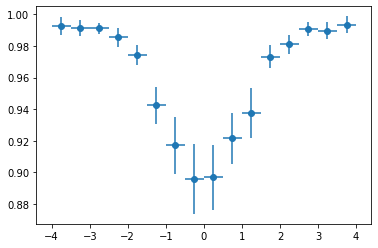

In [9]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:]) / 2
plt.errorbar(eta_center, eta_eff_reshape.mean(0), eta_eff_reshape.std(0), eta_width/2, fmt="o")
# plt.ylim(0.96, 1.005)

(0.7, 1.005)

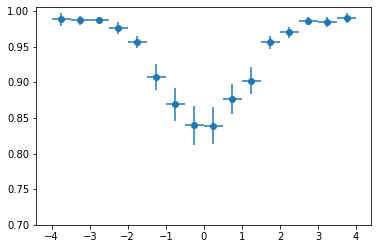

In [31]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:]) / 2
plt.errorbar(eta_center, eta_eff_reshape.mean(0), eta_eff_reshape.std(0), eta_width/2, fmt="o")
plt.ylim(0.7, 1.005)

True positives of signal matching PIDs

<ErrorbarContainer object of 3 artists>

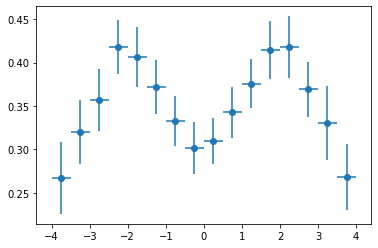

In [10]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:]) / 2
plt.errorbar(eta_center, eta_signal_pur_reshape.mean(0), eta_signal_pur_reshape.std(0), eta_width/2, fmt="o")
# plt.ylim(0., 0.007)

True positives of all matching PIDs

<ErrorbarContainer object of 3 artists>

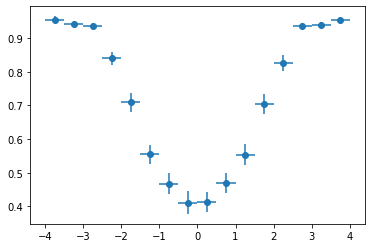

In [11]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:]) / 2
plt.errorbar(eta_center, eta_total_pur_reshape.mean(0), eta_total_pur_reshape.std(0), eta_width/2, fmt="o")
# plt.ylim(0., 0.007)

In [58]:
edge_cut = 0.5
pt_min, pt_max = 1000, 10000
pt_cuts = np.logspace(np.log10(pt_min), np.log10(pt_max), 20)
batch_range = np.arange(0, 50)

pt_eff_list = []
pt_pur_list = []

for batch_idx in tqdm(batch_range):

    batch = model.testset[batch_idx].to(device)

    
    preds, scores, truth, _ = get_performance(
        model, batch, edge_cut
    )
    
    edge_preds = batch.edge_index[:, preds]
    edge_truth = batch.edge_index[:, truth]
    true_positives = truth[preds]
    
    av_pt_preds = (batch.pt[edge_preds[0]] + batch.pt[edge_preds[1]]) / 2
    av_pt_true = (batch.pt[edge_truth[0]] + batch.pt[edge_truth[1]]) / 2

    for pt1, pt2 in zip(pt_cuts[:-1], pt_cuts[1:]):
        edge_pt_pred = (av_pt_preds >= pt1) & (av_pt_preds <= pt2)
        edge_pt_true = (av_pt_true >= pt1) & (av_pt_true <= pt2)
        pt_true_positives = true_positives[edge_pt_pred]

        pt_eff_list.append(
            pt_true_positives.sum().item() / max(1, edge_pt_true.sum().item())
        )
        pt_pur_list.append(
            pt_true_positives.sum().item() / max(1, pt_true_positives.shape[0])
        )

100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


In [59]:
pt_eff_reshape = np.array(pt_eff_list).reshape(len(batch_range), pt_cuts.shape[0] - 1)
pt_pur_reshape = np.array(pt_pur_list).reshape(len(batch_range), pt_cuts.shape[0] - 1)

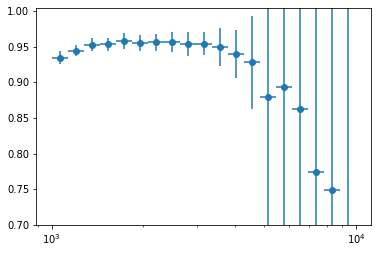

In [60]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:]) / 2
pt_widths = (pt_cuts[1:] - pt_cuts[:-1]) /2
plt.errorbar(pt_center, pt_eff_reshape.mean(0), pt_eff_reshape.std(0), pt_widths, fmt="o")
plt.ylim(0.7, 1.005)
plt.xscale("log")

True positives of signal matching PIDs

(0.7, 1.005)

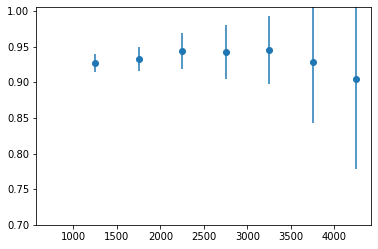

In [34]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:]) / 2
plt.errorbar(pt_center, pt_pur_reshape.mean(0), pt_pur_reshape.std(0), fmt="o")
plt.ylim(0.7, 1.005)

True positives of all matching PIDs

(0.75, 1.005)

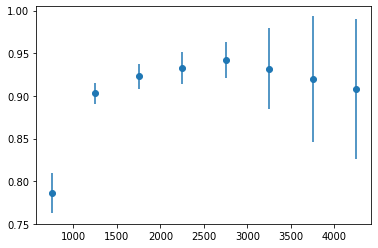

In [96]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:]) / 2
plt.errorbar(pt_center, pt_pur_reshape.mean(0), pt_pur_reshape.std(0), fmt="o")
plt.ylim(0.75, 1.005)

## Predict Tracks

In [9]:
model = model.to(device)
barrel_model = barrel_model.to(device)

In [2]:
from sklearn.cluster import DBSCAN


def tracks_from_gnn(
    hit_id,
    score,
    senders,
    receivers,
    edge_score_cut=0.0,
    epsilon=0.25,
    min_samples=2,
    **kwargs
):

    n_nodes = hit_id.shape[0]
    if edge_score_cut > 0:
        cuts = score > edge_score_cut
        score, senders, receivers = score[cuts], senders[cuts], receivers[cuts]

    # prepare the DBSCAN input, which the adjancy matrix with its value being the edge socre.
    e_csr = sp.sparse.csr_matrix(
        (score, (senders, receivers)), shape=(n_nodes, n_nodes), dtype=np.float32
    )
    # rescale the duplicated edges
    e_csr.data[e_csr.data > 1] = e_csr.data[e_csr.data > 1] / 2.0
    # invert to treat score as an inverse distance
    e_csr.data = 1 - e_csr.data
    # make it symmetric
    e_csr_bi = sp.sparse.coo_matrix(
        (
            np.hstack([e_csr.tocoo().data, e_csr.tocoo().data]),
            np.hstack(
                [
                    np.vstack([e_csr.tocoo().row, e_csr.tocoo().col]),
                    np.vstack([e_csr.tocoo().col, e_csr.tocoo().row]),
                ]
            ),
        )
    )

    # DBSCAN get track candidates
    clustering = DBSCAN(
        eps=epsilon, metric="precomputed", min_samples=min_samples
    ).fit_predict(e_csr_bi)
    track_labels = np.vstack(
        [np.unique(e_csr_bi.tocoo().row), clustering[np.unique(e_csr_bi.tocoo().row)]]
    )
    track_labels = pd.DataFrame(track_labels.T)
    track_labels.columns = ["hit_id", "track_id"]
    new_hit_id = np.apply_along_axis(lambda x: hit_id[x], 0, track_labels.hit_id.values)
    tracks = pd.DataFrame.from_dict(
        {"hit_id": new_hit_id, "track_id": track_labels.track_id}
    )
    return tracks

In [63]:
sample = model.valset[0]

In [64]:
with torch.no_grad():
    results = model.shared_evaluation(sample.to(device), 0, log=False)

In [65]:
sample = sample.cpu()

In [66]:
preds = results["score"][: int(len(results["score"]) / 2)]

In [82]:
reconstructed = tracks_from_gnn(
    sample.hid,
    preds.cpu().numpy(),
    sample.edge_index[0],
    sample.edge_index[1],
    epsilon=0.1,
)

## Debug!

In [27]:
sample.event_file

'/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010596'

In [22]:
from notebooks.ITk.utils import *
# Read yaml config 
with open("tracking_config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Load in files
files = list_files(os.path.join(config["graph_input_dir"], "train"))[:10]

sample = torch.load(files[0], map_location="cpu")

In [8]:
sample.edge_index.shape

torch.Size([2, 535183])

In [23]:
reconstructed = tracks_from_gnn(
    sample.hid,
    sample.y.float().cpu(),
    sample.edge_index[0],
    sample.edge_index[1],
    epsilon=0.1,
)

In [12]:
reconstructed = tracks_from_gnn(
    sample.hid,
    sample.scores.float().cpu(),
    sample.edge_index[0],
    sample.edge_index[1],
    epsilon=0.1,
)

In [29]:
preds = results["score"][: int(len(results["score"]) / 2)]

In [6]:
len(reconstructed.track_id.unique())

14485

In [49]:
particles

,particle_id,subevent,barcode,px,py,pz,pt,eta,vx,vy,vz,radius,status,charge,pdgId,pass,vProdNIn,vProdNOut,vProdStatus,vProdBarcode
0,5,0,5,-58039.0000,19474.5000,19474.5000,61.219100,-0.700640,-0.001258,0.004029,-8.84568,0.004221,22,0.666667,6,NO,2,3,0,-3
1,6,0,6,-67456.8000,-132594.0000,-132594.0000,148.766000,-0.340530,-0.001258,0.004029,-8.84568,0.004221,22,-0.666667,-6,NO,2,3,0,-3
2,7,0,7,125496.0000,113119.0000,113119.0000,168.953000,-3.185210,-0.001258,0.004029,-8.84568,0.004221,23,1.000000,21,NO,2,3,0,-3
3,10,0,10,-90454.3000,29370.4000,29370.4000,95.103100,-0.579145,-0.001258,0.004029,-8.84568,0.004221,44,0.666667,6,NO,1,1,0,-6
4,11,0,11,-111485.0000,-119152.0000,-119152.0000,163.176000,-0.326275,-0.001258,0.004029,-8.84568,0.004221,44,-0.666667,-6,NO,1,1,0,-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99112,68400200072,6840,200072,170.7470,423.3610,423.3610,0.456496,0.312605,-23.469200,-3.507630,1879.09000,23.729900,1,1.000000,1000010020,NO,1,4,1121,-200071
99113,68400200073,6840,200073,-132.6190,-382.7040,-382.7040,0.405031,0.969193,-23.469200,-3.507630,1879.09000,23.729900,1,1.000000,1000010020,NO,1,4,1121,-200071
99114,68400200074,6840,200074,48.6365,298.2550,298.2550,0.302195,0.503916,-23.469200,-3.507630,1879.09000,23.729900,1,-1.000000,-211,NO,1,4,1121,-200071
99115,68401000099,6840,1000099,423.0480,198.5240,198.5240,0.467313,3.331250,19.114700,125.710000,1726.44000,127.155000,1,-1.000000,-211,NO,1,2,1111,-200065


In [38]:
truth

,hit_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,hardware,cluster_x_1,cluster_y_1,...,phi_angle_1,norm_x,norm_y,norm_z_1,cluster_x_2,cluster_y_2,cluster_z_2,eta_angle_2,phi_angle_2,norm_z_2
0,0,-45.0903,-15.9913,-263.00,0,-1,66810001575,PIXEL,-45.0903,-15.9913,...,1.249050,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.000000,-1.000000,-1.0
1,1,-37.7384,-18.1501,-263.00,1,-1,1220,PIXEL,-37.7384,-18.1501,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.000000,-1.000000,-1.0
2,2,-36.6423,-10.1972,-263.00,2,-1,68210001436,PIXEL,-36.6423,-10.1972,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.000000,-1.000000,-1.0
3,3,-45.6745,-23.1734,-263.00,3,-1,0,PIXEL,-45.6745,-23.1734,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.000000,-1.000000,-1.0
4,4,-39.3053,-19.3953,-263.00,4,-1,66810001946,PIXEL,-39.3053,-19.3953,...,1.249050,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.000000,-1.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355217,353712,919.5980,-114.1280,2854.25,489874,489885,0,STRIP,930.5390,-115.6970,...,0.006379,0.0,0.0,1.0,930.588,-115.304,2860.75,1.324640,0.006379,-1.0
355218,353713,923.4590,-115.9750,2854.25,489875,489884,0,STRIP,930.3800,-116.9730,...,0.006379,0.0,0.0,1.0,930.409,-116.741,2860.75,1.324640,0.006379,-1.0
355219,353714,900.6060,-112.6450,2854.25,489875,489885,0,STRIP,930.3800,-116.9730,...,0.006379,0.0,0.0,1.0,930.588,-115.304,2860.75,1.324640,0.006379,-1.0
355220,353715,901.9260,-128.9420,2854.25,489876,489883,66900000128,STRIP,928.1910,-133.2290,...,0.006379,0.0,0.0,1.0,928.337,-132.209,2860.75,1.324640,0.006379,-1.0


In [50]:
(~particles.particle_id.isin(sample.pid.numpy())).sum()

89909

In [51]:
np.isin(np.unique(sample.pid.numpy()), particles.particle_id).sum()

9208

In [52]:
particles[particles.particle_id.isin(sample.pid.numpy())]

,particle_id,subevent,barcode,px,py,pz,pt,eta,vx,vy,vz,radius,status,charge,pdgId,pass,vProdNIn,vProdNOut,vProdStatus,vProdBarcode
449,661,0,661,11158.800,16261.300,16261.300,19.721700,-1.276430,-0.001258,0.004029,-8.84568,0.004221,1,1.0,-13,YES,1,2,0,-505
452,668,0,668,-1156.050,-532.229,-532.229,1.272680,0.214885,-0.001258,0.004029,-8.84568,0.004221,1,-1.0,11,YES,1,2,0,-509
477,700,0,700,298.064,377.502,377.502,0.480988,-2.407250,-0.001258,0.004029,-8.84568,0.004221,1,-1.0,-321,NO,3,5,0,-540
484,711,0,711,304.109,-409.381,-409.381,0.509975,-0.406456,-0.001258,0.004029,-8.84568,0.004221,1,-1.0,-211,NO,3,5,0,-544
485,712,0,712,-527.574,-876.848,-876.848,1.023330,-1.157520,-0.001258,0.004029,-8.84568,0.004221,1,1.0,211,YES,3,5,0,-544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99090,68400200011,6840,200011,261.702,-379.634,-379.634,0.461096,1.440590,20.549400,-36.314400,101.88900,41.725400,1,1.0,211,NO,1,1,1201,-200039
99097,68400200038,6840,200038,-296.832,136.722,136.722,0.326806,0.198320,77.435400,247.393000,535.77100,259.228000,1,1.0,2212,NO,1,7,1121,-200054
99098,68400200040,6840,200040,256.991,499.641,499.641,0.561859,0.334338,77.435400,247.393000,535.77100,259.228000,1,1.0,2212,NO,1,7,1121,-200054
99099,68400200041,6840,200041,-320.753,-358.248,-358.248,0.480858,0.737052,77.435400,247.393000,535.77100,259.228000,1,1.0,2212,NO,1,7,1121,-200054


In [17]:
sample.y.sum() / sample.signal_true_edges.shape[1]

tensor(0.9738)

In [16]:
sample

Data(x=[116663, 3], cell_data=[116663, 11], pid=[116663], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010596', hid=[116663], pt=[116663], primary=[116663], nhits=[116663], modulewise_true_edges=[2, 45817], signal_true_edges=[2, 6840], edge_index=[2, 582011], y=[582011], pedigree=[1], y_pid=[582011], pid_signal=[582011])

## Evaluate Tracks

In [9]:
def get_truth(evtid, raw_csv_path):
    """Return dataframes of true tracks and particles from CSV files."""

    file_prefix = os.path.join(raw_csv_path, "event00001{:04}".format(evtid))

    truth_fname = file_prefix + "-truth.csv"
    particle_fname = file_prefix + "-particles.csv"

    truth = pd.read_csv(truth_fname)
    # <TODO: why are there duplicated hit-id?, >
    truth.drop_duplicates(subset=["hit_id"], inplace=True)

    particles = pd.read_csv(particle_fname)
    particles["pt"] = particles.pt / 1000.0  # to be GeV

    return truth, particles

In [10]:
def evaluate_reco_tracks(
    truth: pd.DataFrame,
    reconstructed: pd.DataFrame,
    particles: pd.DataFrame,
    min_hits_truth=9,
    min_hits_reco=5,
    min_pt=1.0,
    max_pt=np.inf,
    max_eta=2.0,
    frac_reco_matched=0.5,
    frac_truth_matched=0.5,
    **kwargs
):
    """Return


    Args:
        truth: a dataframe with columns of ['hit_id', 'particle_id']
        reconstructed: a dataframe with columns of ['hit_id', 'track_id']
        particles: a dataframe with columns of
            ['particle_id', 'pt', 'eta', 'radius', 'vz'].
            where radius = sqrt(vx**2 + vy**2) and
            ['vx', 'vy', 'vz'] are the production vertex of the particle
        min_hits_truth: minimum number of hits for truth tracks
        min_hits_reco:  minimum number of hits for reconstructed tracks

    Returns:
        A tuple of (
            n_true_tracks: int, number of true tracks
            n_reco_tracks: int, number of reconstructed tracks
            n_matched_reco_tracks: int, number of reconstructed tracks
                matched to true tracks
            matched_pids: np.narray, a list of particle IDs matched
                by reconstructed tracks
        )
    """
    particles = particles[(particles.pt > min_pt) & (particles.eta.abs() < max_eta)]
    
    # just in case particle_id == 0 included in truth.
    if "particle_id" in truth.columns:
        truth = truth[truth.particle_id > 0]

    # get number of spacepoints in each reconstructed tracks
    n_reco_hits = (
        reconstructed.track_id.value_counts(sort=False)
        .reset_index()
        .rename(columns={"index": "track_id", "track_id": "n_reco_hits"})
    )

    # only tracks with a minimum number of spacepoints are considered
    n_reco_hits = n_reco_hits[n_reco_hits.n_reco_hits >= min_hits_reco]
    
    reconstructed = reconstructed[
        reconstructed.track_id.isin(n_reco_hits.track_id.values)
    ]

    # get number of spacepoints in each particle
    hits = truth.merge(particles, on="particle_id", how="left")
    n_true_hits = (
        hits.particle_id.value_counts(sort=False)
        .reset_index()
        .rename(columns={"index": "particle_id", "particle_id": "n_true_hits"})
    )
    

    # only particles leaves at least min_hits_truth spacepoints
    # and with pT >= min_pt are considered.
    particles = particles.merge(n_true_hits, on=["particle_id"], how="left")

    is_trackable = particles.n_true_hits >= min_hits_truth

    # event has 3 columnes [track_id, particle_id, hit_id]
    event = pd.merge(reconstructed, truth, on=["hit_id"], how="left")

    # n_common_hits and n_shared should be exactly the same
    # for a specific track id and particle id

    # Each track_id will be assigned to multiple particles.
    # To determine which particle the track candidate is matched to,
    # we use the particle id that yields a maximum value of n_common_hits / n_reco_hits,
    # which means the majority of the spacepoints associated with the reconstructed
    # track candidate comes from that true track.
    # However, the other way may not be true.
    reco_matching = (
        event.groupby(["track_id", "particle_id"])
        .size()
        .reset_index()
        .rename(columns={0: "n_common_hits"})
    )

    # Each particle will be assigned to multiple reconstructed tracks
    truth_matching = (
        event.groupby(["particle_id", "track_id"])
        .size()
        .reset_index()
        .rename(columns={0: "n_shared"})
    )

    # add number of hits to each of the maching dataframe
    reco_matching = reco_matching.merge(n_reco_hits, on=["track_id"], how="left")
    truth_matching = truth_matching.merge(n_true_hits, on=["particle_id"], how="left")

    # calculate matching fraction
    reco_matching = reco_matching.assign(
        purity_reco=np.true_divide(
            reco_matching.n_common_hits, reco_matching.n_reco_hits
        )
    )
    truth_matching = truth_matching.assign(
        purity_true=np.true_divide(truth_matching.n_shared, truth_matching.n_true_hits)
    )

    # select the best match
    reco_matching["purity_reco_max"] = reco_matching.groupby("track_id")[
        "purity_reco"
    ].transform(max)
    truth_matching["purity_true_max"] = truth_matching.groupby("track_id")[
        "purity_true"
    ].transform(max)

    matched_reco_tracks = reco_matching[
        (reco_matching.purity_reco_max >= frac_reco_matched)
        & (reco_matching.purity_reco == reco_matching.purity_reco_max)
    ]

    matched_true_particles = truth_matching[
        (truth_matching.purity_true_max >= frac_truth_matched)
        & (truth_matching.purity_true == truth_matching.purity_true_max)
    ]

    # now, let's combine the two majority criteria
    # reconstructed tracks must be in both matched dataframe
    # and the so matched particle should be the same
    # in this way, each track should be only assigned
    combined_match = matched_true_particles.merge(
        matched_reco_tracks, on=["track_id", "particle_id"], how="inner"
    )

    n_reco_tracks = n_reco_hits.shape[0]
    n_true_tracks = particles.shape[0]

    # For GNN, there are non-negaliable cases where GNN-based
    # track candidates are matched to particles not considered as interesting.
    # which means there are paticles in matched_pids that do not exist in particles.
    matched_pids = np.unique(combined_match.particle_id)

    is_matched = particles.particle_id.isin(matched_pids).values
    n_matched_particles = np.sum(is_matched)

    n_matched_tracks = reco_matching[
        reco_matching.purity_reco >= frac_reco_matched
    ].shape[0]
    n_matched_tracks_poi = reco_matching[
        (reco_matching.purity_reco >= frac_reco_matched)
        & (reco_matching.particle_id.isin(particles.particle_id.values))
    ].shape[0]
    # print(n_matched_tracks_poi, n_matched_tracks)

    # num_particles_matched_to = reco_matched.groupby("particle_id")['track_id']\
    #     .count().reset_index().rename(columns={"track_id": "n_tracks_matched"})
    # n_duplicated_tracks = num_particles_matched_to.shape[0]
    n_duplicated_tracks = n_matched_tracks_poi - n_matched_particles

    particles = particles.assign(is_matched=is_matched, is_trackable=is_trackable)

    return (
        n_true_tracks,
        n_reco_tracks,
        n_matched_particles,
        n_matched_tracks,
        n_duplicated_tracks,
        n_matched_tracks_poi,
        particles,
    )

In [14]:
sample = model.valset[0]

In [123]:
sample = barrel_model.valset[0]

In [124]:
with torch.no_grad():
    results = model.shared_evaluation(sample.to(device), 0, log=False)
    barrel_results = barrel_model.shared_evaluation(sample.to(device), 0, log=False)

In [125]:
sample = sample.cpu()

In [126]:
preds = results["score"][: int(len(results["score"]) / 2)]
barrel_preds = barrel_results["score"][: int(len(barrel_results["score"]) / 2)]

In [146]:
reconstructed = tracks_from_gnn(
    sample.hid,
    barrel_preds.cpu().numpy(),
    sample.edge_index[0],
    sample.edge_index[1],
    epsilon=0.2,
)

In [39]:
eta = calc_eta(sample.x[:, 0], sample.x[:, 2])
barrel_edges = (eta[sample.edge_index[0]] + eta[sample.edge_index[1]])/2 < 4

In [59]:
barrel_reconstructed = tracks_from_gnn(
    sample.hid,
    barrel_preds[barrel_edges].cpu().numpy(),
    sample.edge_index[0, barrel_edges],
    sample.edge_index[1, barrel_edges],
    epsilon=0.1,
)

In [24]:
truth, particles = get_truth(
    int(sample.event_file[-4:]),
    "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
)

In [148]:
truth = truth[truth.barrel_endcap == 0]

In [25]:
(
    n_true_tracks,
    n_reco_tracks,
    n_matched_true_tracks,
    n_matched_reco_tracks,
    n_duplicated_reco_tracks,
    n_matched_reco_tracks_poi,
    particles,
) = evaluate_reco_tracks(
    truth, reconstructed, particles, min_pt=1., max_eta=4.0, min_hits_truth=9, min_hits_reco=5
)

In [26]:
print(
    (
        n_true_tracks,
        n_reco_tracks,
        n_matched_true_tracks,
        n_matched_reco_tracks,
        n_duplicated_reco_tracks,
        n_matched_reco_tracks_poi,
    )
)

(19040, 1067, 1027, 1066, 39, 1066)


In [27]:
(particles.is_trackable & particles.is_matched).sum(), particles.is_trackable.sum()

(918, 1033)

In [28]:
eff = (
    particles.is_trackable & particles.is_matched
).sum() / particles.is_trackable.sum()
pur = n_matched_reco_tracks / n_reco_tracks

Full on full

In [29]:
print("Efficiency:", eff, "Purity:", pur)

Efficiency: 0.888673765730881 Purity: 0.9990627928772259


Barrel on full

In [69]:
print("Efficiency:", eff, "Purity:", pur)

Efficiency: 0.8762214983713354 Purity: 0.9981617647058824


Full on barrel

In [82]:
print("Efficiency:", eff, "Purity:", pur)

Efficiency: 0.738831615120275 Purity: 0.9810554803788903


Barrel on barrel

In [152]:
print("Efficiency:", eff, "Purity:", pur)

Efficiency: 0.850356294536817 Purity: 0.9691629955947136


## Breakdown

In [106]:
reconstructed = tracks_from_gnn(
    sample.hid,
    preds.cpu().numpy(),
    sample.edge_index[0],
    sample.edge_index[1],
    epsilon=0.15,
)

# reconstructed = tracks_from_gnn(
#     sample.hid,
#     preds.cpu().numpy()[sample.y.bool()],
#     sample.edge_index[0][sample.y.bool()],
#     sample.edge_index[1][sample.y.bool()],
#     epsilon=0.1,
# )

In [109]:
(preds > 0.9).sum()

tensor(10641, device='cuda:0')

In [110]:
reconstructed.track_id.unique()

array([  -1,    0,    1, ..., 1335, 1336, 1337])

In [111]:
reconstructed

,hit_id,track_id
0,84206,-1
1,84207,-1
2,84208,-1
3,84209,-1
4,84210,-1
...,...,...
91028,277531,-1
91029,277532,-1
91030,277533,-1
91031,277534,-1


In [112]:
truth, particles = get_truth(
    int(sample.event_file[-4:]),
    "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
)

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000011820


In [113]:
min_hits_truth=9
min_hits_reco=5
min_pt=1.0
max_eta=2.0
frac_reco_matched=0.5
frac_truth_matched=0.5

In [114]:
particles = particles[(particles.pt > min_pt) & (particles.eta.abs() < max_eta)]

In [115]:
truth = truth[truth.barrel_endcap == 0]

In [116]:
particles

,particle_id,subevent,barcode,px,py,pz,pt,eta,vx,vy,vz,radius,status,charge,pdgId,pass,vProdNIn,vProdNOut,vProdStatus,vProdBarcode
1,6,0,6,-139732.0000,43639.200,43639.200,146.38800,1.585920,-0.005853,0.013352,-100.783,0.014579,22,-0.666667,-6,NO,2,3,0,-3
4,11,0,11,-152673.0000,32366.400,32366.400,156.06600,1.578210,-0.005853,0.013352,-100.783,0.014579,44,-0.666667,-6,NO,1,1,0,-7
8,17,0,17,-149987.0000,28399.600,28399.600,152.65200,1.626340,-0.005853,0.013352,-100.783,0.014579,44,-0.666667,-6,NO,1,1,0,-12
10,19,0,19,20673.6000,17979.500,17979.500,27.39820,-1.998180,-0.005853,0.013352,-100.783,0.014579,44,1.000000,21,NO,1,1,0,-14
11,20,0,20,-7692.5200,11360.600,11360.600,13.72000,0.618350,-0.005853,0.013352,-100.783,0.014579,43,1.000000,21,NO,1,2,0,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83383,67930200881,6793,200881,1284.3300,-228.212,-228.212,1.30445,-1.446360,115.637000,49.694900,-2778.940,125.863000,1,1.000000,211,NO,1,2,1121,-200588
83384,67930200883,6793,200883,1350.8100,328.487,328.487,1.39018,-1.297940,225.864000,30.114500,-3004.410,227.862000,1,1.000000,211,NO,1,2,1121,-200589
83480,67930201038,6793,201038,105.1700,-1201.190,-1201.190,1.20579,-0.753422,-106.295000,-181.632000,-20105.600,210.449000,1,1.000000,2212,NO,1,2,1121,-200672
83491,67930201057,6793,201057,423.3200,-1219.880,-1219.880,1.29124,-1.871470,-110.821000,-74.317800,-20181.500,133.433000,1,-1.000000,-211,NO,1,9,1121,-200680


In [117]:
# just in case particle_id == 0 included in truth.
if "particle_id" in truth.columns:
    truth = truth[truth.particle_id > 0]

In [118]:
# get number of spacepoints in each reconstructed tracks
n_reco_hits = (
    reconstructed.track_id.value_counts(sort=False)
    .reset_index()
    .rename(columns={"index": "track_id", "track_id": "n_reco_hits"})
)
n_reco_hits = n_reco_hits[n_reco_hits.track_id >= 0]

In [120]:
# only tracks with a minimum number of spacepoints are considered
n_reco_hits = n_reco_hits[n_reco_hits.n_reco_hits >= min_hits_reco]

reconstructed = reconstructed[
    reconstructed.track_id.isin(n_reco_hits.track_id.values)
]

In [121]:
reconstructed.track_id.unique().shape

(895,)

In [122]:
n_reco_hits

,track_id,n_reco_hits
4,3,7
8,7,8
9,8,10
10,9,5
12,11,6
...,...,...
1229,1228,6
1238,1237,5
1264,1263,5
1278,1277,5


In [123]:
# get number of spacepoints in each particle
hits = truth.merge(particles, on="particle_id", how="left")
n_true_hits = (
    hits.particle_id.value_counts(sort=False)
    .reset_index()
    .rename(columns={"index": "particle_id", "particle_id": "n_true_hits"})
)

In [124]:
n_true_hits

,particle_id,n_true_hits
0,67920000960,3
1,67220000504,1
2,66890000924,1
3,67210001387,1
4,66260000140,1
...,...,...
8401,67090200050,1
8402,67690200329,1
8403,66120200016,1
8404,66150200078,1


In [125]:
# only particles leaves at least min_hits_truth spacepoints
# and with pT >= min_pt are considered.
particles = particles.merge(n_true_hits, on=["particle_id"], how="left")

is_trackable = particles.n_true_hits >= min_hits_truth

# event has 3 columns [track_id, particle_id, hit_id]
event = pd.merge(reconstructed, truth[["hit_id", "particle_id"]], on=["hit_id"], how="left")

In [126]:
is_trackable.sum()

462

In [127]:
reco_matching = (
    event.groupby(["track_id", "particle_id"])
    .size()
    .reset_index()
    .rename(columns={0: "n_common_hits"})
)

In [128]:
reco_matching

,track_id,particle_id,n_common_hits
0,3,6.619000e+10,6
1,7,6.220000e+02,8
2,8,6.619000e+10,9
3,8,6.758000e+10,1
4,9,6.678000e+10,1
...,...,...,...
1084,1237,6.676020e+10,5
1085,1263,6.793000e+10,5
1086,1277,6.782000e+10,1
1087,1277,6.782020e+10,2


In [129]:
# Each particle will be assigned to multiple reconstructed tracks
truth_matching = (
    event.groupby(["particle_id", "track_id"])
    .size()
    .reset_index()
    .rename(columns={0: "n_shared"})
)

In [130]:
truth_matching

,particle_id,track_id,n_shared
0,4.070000e+02,316,7
1,4.570000e+02,959,7
2,4.620000e+02,930,6
3,5.110000e+02,461,5
4,6.040000e+02,238,8
...,...,...,...
1084,6.793000e+10,817,1
1085,6.793000e+10,186,10
1086,6.793020e+10,1035,6
1087,6.793020e+10,1118,8


In [131]:
# add number of hits to each of the maching dataframe
reco_matching = reco_matching.merge(n_reco_hits, on=["track_id"], how="left")
truth_matching = truth_matching.merge(n_true_hits, on=["particle_id"], how="left")

In [132]:
# calculate matching fraction
reco_matching = reco_matching.assign(
    purity_reco=np.true_divide(
        reco_matching.n_common_hits, reco_matching.n_reco_hits
    )
)
truth_matching = truth_matching.assign(
    purity_true=np.true_divide(truth_matching.n_shared, truth_matching.n_true_hits)
)

In [133]:
reco_matching

,track_id,particle_id,n_common_hits,n_reco_hits,purity_reco
0,3,6.619000e+10,6,7,0.857143
1,7,6.220000e+02,8,8,1.000000
2,8,6.619000e+10,9,10,0.900000
3,8,6.758000e+10,1,10,0.100000
4,9,6.678000e+10,1,5,0.200000
...,...,...,...,...,...
1084,1237,6.676020e+10,5,5,1.000000
1085,1263,6.793000e+10,5,5,1.000000
1086,1277,6.782000e+10,1,5,0.200000
1087,1277,6.782020e+10,2,5,0.400000


In [134]:
truth_matching

,particle_id,track_id,n_shared,n_true_hits,purity_true
0,4.070000e+02,316,7,9,0.777778
1,4.570000e+02,959,7,11,0.636364
2,4.620000e+02,930,6,8,0.750000
3,5.110000e+02,461,5,6,0.833333
4,6.040000e+02,238,8,11,0.727273
...,...,...,...,...,...
1084,6.793000e+10,817,1,12,0.083333
1085,6.793000e+10,186,10,10,1.000000
1086,6.793020e+10,1035,6,6,1.000000
1087,6.793020e+10,1118,8,8,1.000000


In [135]:
# select the best match
reco_matching["purity_reco_max"] = reco_matching.groupby("track_id")[
    "purity_reco"
].transform(max)
truth_matching["purity_true_max"] = truth_matching.groupby("track_id")[
    "purity_true"
].transform(max)

In [136]:
matched_reco_tracks = reco_matching[
    (reco_matching.purity_reco_max >= frac_reco_matched)
    & (reco_matching.purity_reco == reco_matching.purity_reco_max)
]

matched_true_particles = truth_matching[
    (truth_matching.purity_true_max >= frac_truth_matched)
    & (truth_matching.purity_true == truth_matching.purity_true_max)
]


In [137]:
combined_match = matched_true_particles.merge(
    matched_reco_tracks, on=["track_id", "particle_id"], how="inner"
)

n_reco_tracks = n_reco_hits.shape[0]
n_true_tracks = particles.shape[0]

In [138]:
n_reco_tracks, n_true_tracks

(895, 11764)

In [139]:
matched_pids = np.unique(combined_match.particle_id)

In [140]:
matched_pids.shape

(861,)

In [141]:
is_matched = particles.particle_id.isin(matched_pids).values
n_matched_particles = np.sum(is_matched)

In [142]:
n_matched_tracks = reco_matching[
    reco_matching.purity_reco >= frac_reco_matched
].shape[0]
n_matched_tracks_poi = reco_matching[
    (reco_matching.purity_reco >= frac_reco_matched)
    & (reco_matching.particle_id.isin(particles.particle_id.values))
].shape[0]

In [143]:
n_matched_tracks, n_matched_tracks_poi

(886, 613)

In [144]:
n_duplicated_tracks = n_matched_tracks_poi - n_matched_particles

particles = particles.assign(is_matched=is_matched, is_trackable=is_trackable)

In [145]:
n_duplicated_tracks

7

In [146]:
eff = (
        particles.is_trackable & particles.is_matched
    ).sum() / particles.is_trackable.sum()
    

In [147]:
pur = n_matched_tracks / n_reco_tracks

In [100]:
eff

0.7252396166134185

In [101]:
pur

0.9899441340782122

In [149]:
eff

0.8961038961038961

In [148]:
pur

0.9899441340782122

## Studies

### Epsilon

In [156]:
for epsilon in np.linspace(0.01, 0.2, 10):

    sample = model.trainset[0].cpu()
    with torch.no_grad():
        results = model.shared_evaluation(sample.to(device), 0, log=False)
    sample = sample.cpu()
    preds = results["score"][: int(len(results["score"]) / 2)]
    reconstructed = tracks_from_gnn(
        sample.hid,
        preds.cpu(),
        sample.edge_index[0],
        sample.edge_index[1],
        epsilon=epsilon,
    )

    truth, particles = get_truth(
        int(sample.event_file[-4:]),
        "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
    )
    truth = truth[truth.barrel_endcap == 0]
    (
        n_true_tracks,
        n_reco_tracks,
        n_matched_true_tracks,
        n_matched_reco_tracks,
        n_duplicated_reco_tracks,
        n_matched_reco_tracks_poi,
        particles,
    ) = evaluate_reco_tracks(
        truth,
        reconstructed,
        min_hits_truth=9,
        min_hits_reco=3,
        particles=particles,
        min_pt=1.,
        max_eta=1.,
    )

    eff = (
        particles.is_trackable & particles.is_matched
    ).sum() / particles.is_trackable.sum()
    pur = n_matched_reco_tracks / n_reco_tracks
    print("Epsilon:", epsilon, "Efficiency:", eff, "Purity:", pur)

Epsilon: 0.01 Efficiency: 0.7770700636942676 Purity: 0.9987864077669902
Epsilon: 0.03111111111111111 Efficiency: 0.8375796178343949 Purity: 0.9923497267759562
Epsilon: 0.052222222222222225 Efficiency: 0.8535031847133758 Purity: 0.9854014598540146
Epsilon: 0.07333333333333333 Efficiency: 0.8598726114649682 Purity: 0.9827586206896551
Epsilon: 0.09444444444444444 Efficiency: 0.8662420382165605 Purity: 0.9802176063303659
Epsilon: 0.11555555555555555 Efficiency: 0.8598726114649682 Purity: 0.9746588693957114
Epsilon: 0.1366666666666667 Efficiency: 0.856687898089172 Purity: 0.9711815561959655
Epsilon: 0.1577777777777778 Efficiency: 0.8439490445859873 Purity: 0.9644194756554307
Epsilon: 0.1788888888888889 Efficiency: 0.8471337579617835 Purity: 0.9646182495344506
Epsilon: 0.2 Efficiency: 0.8343949044585988 Purity: 0.9540863177226814


In [158]:
for epsilon in np.linspace(0.01, 0.2, 10):

    sample = model.trainset[0].cpu()
    with torch.no_grad():
        results = model.shared_evaluation(sample.to(device), 0, log=False)
    sample = sample.cpu()
    preds = results["score"][: int(len(results["score"]) / 2)]
    reconstructed = tracks_from_gnn(
        sample.hid,
        preds.cpu(),
        sample.edge_index[0],
        sample.edge_index[1],
        epsilon=epsilon,
    )

    truth, particles = get_truth(
        int(sample.event_file[-4:]),
        "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
    )
    truth = truth[truth.barrel_endcap == 0]
    (
        n_true_tracks,
        n_reco_tracks,
        n_matched_true_tracks,
        n_matched_reco_tracks,
        n_duplicated_reco_tracks,
        n_matched_reco_tracks_poi,
        particles,
    ) = evaluate_reco_tracks(
        truth,
        reconstructed,
        min_hits_truth=9,
        min_hits_reco=3,
        particles=particles,
        min_pt=1.,
        max_eta=2.,
    )

    eff = (
        particles.is_trackable & particles.is_matched
    ).sum() / particles.is_trackable.sum()
    pur = n_matched_reco_tracks / n_reco_tracks
    print("Epsilon:", epsilon, "Efficiency:", eff, "Purity:", pur)

Epsilon: 0.01 Efficiency: 0.8066037735849056 Purity: 0.9987864077669902
Epsilon: 0.03111111111111111 Efficiency: 0.8584905660377359 Purity: 0.9923497267759562
Epsilon: 0.052222222222222225 Efficiency: 0.8726415094339622 Purity: 0.9854014598540146
Epsilon: 0.07333333333333333 Efficiency: 0.8797169811320755 Purity: 0.9817444219066938
Epsilon: 0.09444444444444444 Efficiency: 0.8891509433962265 Purity: 0.9802176063303659
Epsilon: 0.11555555555555555 Efficiency: 0.8820754716981132 Purity: 0.9746588693957114
Epsilon: 0.1366666666666667 Efficiency: 0.8820754716981132 Purity: 0.9702495201535508
Epsilon: 0.1577777777777778 Efficiency: 0.8726415094339622 Purity: 0.9643861293345829
Epsilon: 0.1788888888888889 Efficiency: 0.875 Purity: 0.9646182495344506
Epsilon: 0.2 Efficiency: 0.8655660377358491 Purity: 0.9540863177226814


### Min Hits

In [113]:
for min_hits_truth in np.arange(7, 12):
    for min_hits_reco in np.arange(3, 8):

        sample = model.trainset[0].cpu()
        with torch.no_grad():
            results = model.shared_evaluation(sample.to(device), 0, log=False)
        sample = sample.cpu()
        preds = results["score"][: int(len(results["score"]) / 2)]
        reconstructed = tracks_from_gnn(
            sample.hid,
            preds.cpu(),
            sample.edge_index[0],
            sample.edge_index[1],
            epsilon=0.1,
        )

        truth, particles = get_truth(
            int(sample.event_file[-4:]),
            "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
        )

        (
            n_true_tracks,
            n_reco_tracks,
            n_matched_true_tracks,
            n_matched_reco_tracks,
            n_duplicated_reco_tracks,
            n_matched_reco_tracks_poi,
            particles,
        ) = evaluate_reco_tracks(
            truth,
            reconstructed,
            min_hits_truth=min_hits_truth,
            min_hits_reco=min_hits_reco,
            particles=particles,
            min_pt=1.,
            max_eta=4.,
        )

        eff = (
            particles.is_trackable & particles.is_matched
        ).sum() / particles.is_trackable.sum()
        pur = n_matched_reco_tracks / n_reco_tracks
        print("N hits truth:", min_hits_truth, "N hits reco:", min_hits_reco, "Efficiency:", eff, "Purity:", pur)

N hits truth: 7 N hits reco: 3 Efficiency: 0.8697829716193656 Purity: 0.9850642584230636
N hits truth: 7 N hits reco: 4 Efficiency: 0.8697829716193656 Purity: 0.9916698220371072
N hits truth: 7 N hits reco: 5 Efficiency: 0.8647746243739566 Purity: 0.9945286195286195
N hits truth: 7 N hits reco: 6 Efficiency: 0.8330550918196995 Purity: 0.9962877030162413
N hits truth: 7 N hits reco: 7 Efficiency: 0.7629382303839732 Purity: 0.9968085106382979
N hits truth: 8 N hits reco: 3 Efficiency: 0.8862068965517241 Purity: 0.9850642584230636
N hits truth: 8 N hits reco: 4 Efficiency: 0.8862068965517241 Purity: 0.9916698220371072
N hits truth: 8 N hits reco: 5 Efficiency: 0.8810344827586207 Purity: 0.9945286195286195
N hits truth: 8 N hits reco: 6 Efficiency: 0.8482758620689655 Purity: 0.9962877030162413
N hits truth: 8 N hits reco: 7 Efficiency: 0.7793103448275862 Purity: 0.9968085106382979
N hits truth: 9 N hits reco: 3 Efficiency: 0.8998144712430427 Purity: 0.9850642584230636
N hits truth: 9 N hit

### Eta Dependence

In [117]:
eta_width = 0.5
for eta_min in np.arange(0, 3.6, 0.5):

    sample = model.trainset[0].cpu()
    with torch.no_grad():
        results = model.shared_evaluation(sample.to(device), 0, log=False)
    sample = sample.cpu()
    preds = results["score"][: int(len(results["score"]) / 2)]
    reconstructed = tracks_from_gnn(
        sample.hid,
        preds.cpu(),
        sample.edge_index[0],
        sample.edge_index[1],
        epsilon=0.15,
    )

    truth, particles = get_truth(
        int(sample.event_file[-4:]),
        "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
    )

    (
        n_true_tracks,
        n_reco_tracks,
        n_matched_true_tracks,
        n_matched_reco_tracks,
        n_duplicated_reco_tracks,
        n_matched_reco_tracks_poi,
        particles,
    ) = evaluate_reco_tracks(
        truth,
        reconstructed,
        min_hits_truth=10,
        min_hits_reco=5,
        particles=particles,
        min_pt=1.,
        min_eta=eta_min,
        max_eta=eta_min+eta_width,
    )

    eff = (
        particles.is_trackable & particles.is_matched
    ).sum() / particles.is_trackable.sum()
    pur = n_matched_reco_tracks / n_reco_tracks
    print("Eta_bin:", eta_min, "Efficiency:", eff, "Purity:", pur)

Eta_bin: 0.0 Efficiency: 0.8686868686868687 Purity: 0.989191353082466
Eta_bin: 0.5 Efficiency: 0.9175257731958762 Purity: 0.989191353082466
Eta_bin: 1.0 Efficiency: 0.8846153846153846 Purity: 0.989191353082466
Eta_bin: 1.5 Efficiency: 0.8666666666666667 Purity: 0.989191353082466
Eta_bin: 2.0 Efficiency: 0.9261363636363636 Purity: 0.989191353082466
Eta_bin: 2.5 Efficiency: 0.9457831325301205 Purity: 0.989191353082466
Eta_bin: 3.0 Efficiency: 0.9312977099236641 Purity: 0.989191353082466
Eta_bin: 3.5 Efficiency: 0.9603960396039604 Purity: 0.989191353082466


In [118]:
eta_width = 0.5
for eta_min in np.arange(0, 3.6, 0.5):

    sample = model.trainset[0].cpu()
    with torch.no_grad():
        results = model.shared_evaluation(sample.to(device), 0, log=False)
    sample = sample.cpu()
    preds = results["score"][: int(len(results["score"]) / 2)]
    reconstructed = tracks_from_gnn(
        sample.hid,
        preds.cpu(),
        sample.edge_index[0],
        sample.edge_index[1],
        epsilon=0.15,
    )

    truth, particles = get_truth(
        int(sample.event_file[-4:]),
        "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
    )

    (
        n_true_tracks,
        n_reco_tracks,
        n_matched_true_tracks,
        n_matched_reco_tracks,
        n_duplicated_reco_tracks,
        n_matched_reco_tracks_poi,
        particles,
    ) = evaluate_reco_tracks(
        truth,
        reconstructed,
        min_hits_truth=11,
        min_hits_reco=5,
        particles=particles,
        min_pt=1.,
        min_eta=eta_min,
        max_eta=eta_min+eta_width,
    )

    eff = (
        particles.is_trackable & particles.is_matched
    ).sum() / particles.is_trackable.sum()
    pur = n_matched_reco_tracks / n_reco_tracks
    print("Eta_bin:", eta_min, "Efficiency:", eff, "Purity:", pur)

Eta_bin: 0.0 Efficiency: 0.8974358974358975 Purity: 0.989191353082466
Eta_bin: 0.5 Efficiency: 0.9069767441860465 Purity: 0.989191353082466
Eta_bin: 1.0 Efficiency: 0.9230769230769231 Purity: 0.989191353082466
Eta_bin: 1.5 Efficiency: 0.8816568047337278 Purity: 0.989191353082466
Eta_bin: 2.0 Efficiency: 0.9349112426035503 Purity: 0.989191353082466
Eta_bin: 2.5 Efficiency: 0.9627329192546584 Purity: 0.989191353082466
Eta_bin: 3.0 Efficiency: 0.9416666666666667 Purity: 0.989191353082466
Eta_bin: 3.5 Efficiency: 0.9680851063829787 Purity: 0.989191353082466


### Across Samples

In [165]:
eta_width = 0.5
eta_cuts = np.arange(0, 3.6, eta_width)
batch_range = np.arange(0, 200)

eta_eff_list = []
eta_pur_list = []

for batch_idx in tqdm(batch_range):

    sample = model.trainset[batch_idx].cpu()

    with torch.no_grad():
        results = model.shared_evaluation(sample.to(device), 0, log=False)
        
    sample = sample.cpu()
    preds = results["score"][: int(len(results["score"]) / 2)]
    reconstructed = tracks_from_gnn(
        sample.hid,
        preds.cpu(),
        sample.edge_index[0],
        sample.edge_index[1],
        epsilon=0.15,
    )

    for eta_min in eta_cuts:

        truth, particles = get_truth(
        int(sample.event_file[-4:]),
        "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
    )
        
        (
            n_true_tracks,
            n_reco_tracks,
            n_matched_true_tracks,
            n_matched_reco_tracks,
            n_duplicated_reco_tracks,
            n_matched_reco_tracks_poi,
            particles,
        ) = evaluate_reco_tracks(
            truth,
            reconstructed,
            min_hits_truth=11,
            min_hits_reco=5,
            particles=particles,
            min_pt=1.,
            min_eta=eta_min,
            max_eta=eta_min+eta_width,
        )

        eff = (
            particles.is_trackable & particles.is_matched
        ).sum() / particles.is_trackable.sum()
        pur = n_matched_reco_tracks / n_reco_tracks
        
        eta_eff_list.append(eff)
    eta_pur_list.append(pur)
        

100%|██████████| 200/200 [43:41<00:00, 13.11s/it]


In [166]:
eta_eff_reshape = np.array(eta_eff_list).reshape(
     len(batch_range), eta_cuts.shape[0]
)

<ErrorbarContainer object of 3 artists>

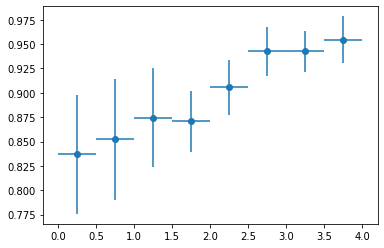

In [136]:
eta_center = (eta_cuts + eta_width/2)
plt.errorbar(eta_center, eta_eff_reshape.mean(0), eta_eff_reshape.std(0), eta_width/2, fmt="o")
# plt.ylim(0.96, 1.005)

<ErrorbarContainer object of 3 artists>

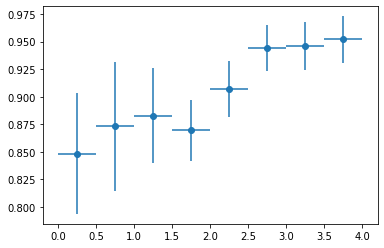

In [167]:
eta_center = (eta_cuts + eta_width/2)
plt.errorbar(eta_center, eta_eff_reshape.mean(0), eta_eff_reshape.std(0), eta_width/2, fmt="o")
# plt.ylim(0.96, 1.005)

In [168]:
print(f"Purity {np.array(eta_pur_list).mean()} +/- {np.array(eta_pur_list).std()}")

Purity 0.9872212209160697 +/- 0.0025795737930946827
